<center>

## Organización de Datos: Trabajo Práctico N° 1 
### (1° Cuatrimestre 2020) 
###  Análisis Exploratorio (Grupo N°1)
</center>
 


In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns

#para deteccion de lenguaje
import icu
import polyglot 
from polyglot.detect import Detector

#para wordclouds
from PIL import *
from wordcloud import WordCloud
import re
from os import path, getcwd

# para locations
import pycountry
import plotly.graph_objects as go
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import plotly.offline as py

# para analisis de texto
from nltk.corpus import stopwords
from collections import defaultdict
import string

#para raincloud
import ptitprince as pt

In [2]:
#codigo para guardar la imagen en una carpeta
savefigs = True
figs_dir = '../figs'

if savefigs:
    # Make the figures folder if it doesn't yet exist
    if not os.path.isdir('figs'):
        os.makedirs('figs')

In [3]:
df = pd.read_csv('data/train.csv')

In [4]:
df.shape

(7613, 5)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
def named_series_plot(named_series, title='', xlabel='', ylabel='', xlabel_fontsize=14, ylabel_fontsize=14, xticks_fontsize=None, title_fontsize=20, xticks_rotation=45, save_fig=False, filename='default_filename'):
    plt.figure(figsize=(12,6))
    bar_names = list(named_series.index)

    plt.bar(bar_names, named_series, width=0.5, log=False)

    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    
    plt.xticks(rotation=xticks_rotation, fontsize=xticks_fontsize)

    plt.title(title, fontsize=20);
    
    if save_fig:
        filename = filename + '.png'
        plt.savefig(filename)

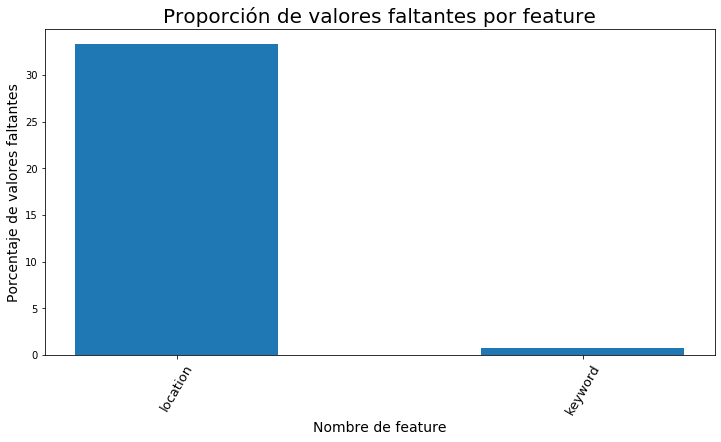

In [117]:
missing = df.isnull().sum()
missing = (missing/df.shape[0])*100
missing = missing[missing > 0]
missing.sort_values(inplace=True, ascending=False)
plt.figure(figsize=(12,6))
bar_names = list(missing.index)
plt.bar(bar_names, missing, width=0.5, log=False)
plt.xlabel('Nombre de feature', fontsize=14)
plt.ylabel('Porcentaje de valores faltantes', fontsize=14)
plt.xticks(rotation=60, fontsize=13)
plt.title('Proporción de valores faltantes por feature', fontsize=20);
if savefigs:
    plt.savefig('figs/missing_values.png', bbox_inches='tight')
plt.show()

In [131]:
missing

location    33.272035
keyword      0.801261
dtype: float64

In [35]:
#hago una columna nueva con la longitud de tweets
df['text_length'] = df['text'].apply(len)

In [6]:
df.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  text_length  
0       1           69  
1       1           38  
2       1          133  
3       1           65  
4       1           88

In [17]:
pd.options.display.max_colwidth

50

In [295]:
#para ver un poco mas en detalle los tweets y ver que se puede extraer ya sea hashtags etc
pd.options.display.max_colwidth = -1

In [19]:
df.iloc[0:0,3]

Series([], Name: text, dtype: object)

In [20]:
pd.options.display.max_colwidth = 50

In [134]:
df_proportion = df[['id','target']]

In [138]:
df_prop_group = df_proportion.groupby('target')['id'].apply(np.size)

In [141]:
df_prop_group.index

Int64Index([0, 1], dtype='int64', name='target')

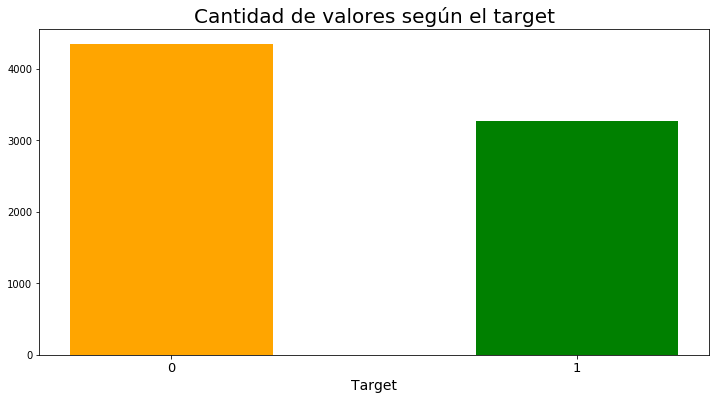

In [155]:
plt.figure(figsize=(12,6))
bar_names = list(df_prop_group.index)
plt.bar(bar_names, df_prop_group, width=0.5,color=['orange','green'])
plt.xlabel('Target', fontsize=14)
plt.xticks([0,1], fontsize=13)
plt.title('Cantidad de valores según el target', fontsize=20);
if savefigs:
    plt.savefig('figs/proportion.png', bbox_inches='tight')
plt.show()

Analisis del lenguaje de los tweets
======

## En teoria esta todo en ingles, pero sera asi?

In [21]:
#saco caracteres invalidos para la liberia
def convert_utf_invalid_characters(x):
    return ''.join(x for x in x if x.isprintable())

In [22]:
df['temp_text'] = df['text'].apply(convert_utf_invalid_characters)

In [ ]:
df.temp_text = df.temp_text.astype(str)
df['poly_obj'] = df.temp_text.apply(lambda x: Detector(x, quiet=True))

In [24]:
df['text_language'] = df['poly_obj'].apply(lambda x: icu.Locale.getDisplayName(x.language.locale))
df['text_lang_confidence'] = df['poly_obj'].apply( lambda x: x.language.confidence)

In [25]:
df['text_lang_confidence'].value_counts()

99.0    3945
98.0    2849
97.0     510
96.0     182
95.0      65
94.0      28
93.0       9
90.0       7
88.0       6
92.0       4
91.0       4
0.0        2
87.0       1
80.0       1
Name: text_lang_confidence, dtype: int64

In [26]:
df['text_language'].value_counts()

inglés                7578
escocés                  6
noruego nynorsk          4
danés                    4
waray                    2
un                       2
portugués                2
eslovaco                 2
latín                    2
estonio                  1
javanés                  1
kinyarwanda              1
galés                    1
oromo                    1
italiano                 1
malayo                   1
manés                    1
setswana                 1
sesotho meridional       1
islandés                 1
Name: text_language, dtype: int64

Analizo aquellos de poca confianza en el detector
------

In [27]:
#para ver un poco mas en detalle los tweets
pd.options.display.max_colwidth = -1

In [28]:
df.loc[df['text_lang_confidence'] == 0,['text']]

text
323   @paddytomlinson1 ARMAGEDDON       
2067  lmfao fucking luis hhahaha im dead

### Los UnknownLanguage son los de poca confianza y es texto en ingles

Analizo aquellos de diferentes idioma en el detector
------

In [29]:
df.loc[df['text_language'] != 'inglés',['text']]

text
323   @paddytomlinson1 ARMAGEDDON                                                                                                                   
336   European Fitba till Christmas  ARMAGEDDON                                                                                                     
362   .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: RT DrAyesha4: #IndiaKoMunTorJawabDo\n\nIndian Army kiÛ_ http://t.co/WJLJq3yA4g
688   @BaseballQuotes1 I have a 32 inch dynasty                                                                                                     
823   @Blizzard_Gamin ight                                                                                                                          
848   @LoneWolffur BRUH *dies*                                                                                                                      
876   #RolandoNaBeats: Ellie Goulding - My Blood | Acesse nosso site para ouvir! http://t.co/Zk69uGXMT8                                             
895   Bloody insomnia again! Grrrr!! #Insomnia                                                                                                      
1034  @Deeeznvtzzz bring the body bags tho                                                                                                          
1450  @5SOSFamUpdater social casualty                                                                                                               
1452  Social Casualty #MTVHottest 5SOS                                                                                                              
2067  lmfao fucking luis hhahaha im dead                                                                                                            
2085  that's it val is dead im suing                                                                                                                
2741  @Keegan172 I'm devastated                                                                                                                     
3087  Let her go - Passenger                                                                                                                        
3663  @Truly_Stings Yo Dm me                                                                                                                        
3667  Fatality!                                                                                                                                     
3670  fatality                                                                                                                                      
3681  @Babybackreeve FATALITY!!!!!!!!!!                                                                                                             
3683  @pxnatosil @RenuncieDilma  Fatality!                                                                                                          
3696  Fatality ????                                                                                                                                 
4315  Hellfire Gargoyle Hoof coil http://t.co/2ii3Brc7NX                                                                                            
4503  Hurricane 30STM quem lembra                                                                                                                   
4873  @BenignoVito @LibertyBell1000 HILLARYMASS MURDERER.                                                                                           
5035  @UrufuSanRagu a Mudslide?                                                                                                                     
5743  @PipRhys I predict a riot.                                                                                                                    
5887  SANDSTORM!!! WOO HOO!!                                                                                             

### En conclusion tenemos todos tweets en ingles salvo 3 que mezclan ingles con otros idiomas, 2 en portugues (indice 876 y 4503) y 1 en español (indice 7586), a tener en cuenta si se quiere hacer un analisis de sentimiento en el futuro, habra que traducir las palabras de su idioma a ingles

In [30]:
pd.options.display.max_colwidth = 50

In [31]:
df.drop(['temp_text','poly_obj','text_language','text_lang_confidence'], axis=1, inplace=True)

# Extraccion de strings para wordclouds

## Hashtags (unicos)

In [12]:
def get_list_length(x):
    return len(x)

In [13]:
def extract_hashtag(x):
    return re.findall(r'#\w+', x)

In [14]:
df['hashtags'] = df['text'].apply(extract_hashtag)
df['hashtags_len'] = df['hashtags'].apply(get_list_length)

In [15]:
df['hashtags_len'].max()

13

In [16]:
h_list = ['h1','h2','h3','h4','h5','h6','h7','h8','h9','h10','h11','h12','h13']

In [17]:
df_ht = pd.DataFrame(df.hashtags.tolist(), index= df.index,columns=h_list)

In [18]:
def remove_ht(x):
    return re.sub('#', '', x)

In [19]:
df_ht = df_ht.astype(str)

In [20]:
df_ht['h1'] = df_ht['h1'].apply(remove_ht)
df_ht['h2'] = df_ht['h2'].apply(remove_ht)
df_ht['h3'] = df_ht['h3'].apply(remove_ht)
df_ht['h4'] = df_ht['h4'].apply(remove_ht)
df_ht['h5'] = df_ht['h5'].apply(remove_ht)
df_ht['h6'] = df_ht['h6'].apply(remove_ht)
df_ht['h7'] = df_ht['h7'].apply(remove_ht)
df_ht['h8'] = df_ht['h8'].apply(remove_ht)
df_ht['h9'] = df_ht['h9'].apply(remove_ht)
df_ht['h10'] = df_ht['h10'].apply(remove_ht)
df_ht['h11'] = df_ht['h11'].apply(remove_ht)
df_ht['h12'] = df_ht['h12'].apply(remove_ht)
df_ht['h13'] = df_ht['h13'].apply(remove_ht)

In [21]:
#dropeo la row 0 que es None
df_ht_1 = df_ht.h1.value_counts().rename_axis('unique_values').reset_index(name='counts').drop(0)
df_ht_2 = df_ht.h2.value_counts().rename_axis('unique_values').reset_index(name='counts').drop(0)
df_ht_3 = df_ht.h3.value_counts().rename_axis('unique_values').reset_index(name='counts').drop(0)
df_ht_4 = df_ht.h4.value_counts().rename_axis('unique_values').reset_index(name='counts').drop(0)
df_ht_5 = df_ht.h5.value_counts().rename_axis('unique_values').reset_index(name='counts').drop(0)
df_ht_6 = df_ht.h6.value_counts().rename_axis('unique_values').reset_index(name='counts').drop(0)
df_ht_7 = df_ht.h7.value_counts().rename_axis('unique_values').reset_index(name='counts').drop(0)
df_ht_8 = df_ht.h8.value_counts().rename_axis('unique_values').reset_index(name='counts').drop(0)
df_ht_9 = df_ht.h9.value_counts().rename_axis('unique_values').reset_index(name='counts').drop(0)
df_ht_10 = df_ht.h10.value_counts().rename_axis('unique_values').reset_index(name='counts').drop(0)
df_ht_11 = df_ht.h11.value_counts().rename_axis('unique_values').reset_index(name='counts').drop(0)
df_ht_12 = df_ht.h12.value_counts().rename_axis('unique_values').reset_index(name='counts').drop(0)
df_ht_13 = df_ht.h13.value_counts().rename_axis('unique_values').reset_index(name='counts').drop(0)

In [22]:
df_tot = df_ht_1.merge(df_ht_2,on='unique_values',how='outer').merge(df_ht_3,on='unique_values',how='outer')\
.merge(df_ht_4,on='unique_values',how='outer').merge(df_ht_5,on='unique_values',how='outer')\
.merge(df_ht_6,on='unique_values',how='outer').merge(df_ht_7,on='unique_values',how='outer')\
.merge(df_ht_8,on='unique_values',how='outer').merge(df_ht_9,on='unique_values',how='outer')\
.merge(df_ht_10,on='unique_values',how='outer').merge(df_ht_11,on='unique_values',how='outer')\
.merge(df_ht_12,on='unique_values',how='outer').merge(df_ht_13,on='unique_values',how='outer')

In [23]:
df_tot.head(5)

unique_values  counts_x  counts_y  counts_x  counts_y  counts_x  counts_y  \
0           hot      31.0       NaN       NaN       NaN       NaN       NaN   
1          news      19.0      16.0       2.0       1.0       NaN       NaN   
2          News      18.0      16.0       1.0       NaN       NaN       NaN   
3     Hiroshima      16.0       4.0       NaN       1.0       NaN       NaN   
4          GBBO      12.0       5.0       NaN       NaN       NaN       NaN   

   counts_x  counts_y  counts_x  counts_y  counts_x  counts_y  counts  
0       NaN       NaN       NaN       NaN       NaN       NaN     NaN  
1       NaN       NaN       NaN       NaN       NaN       NaN     NaN  
2       NaN       NaN       NaN       3.0       NaN       NaN     NaN  
3       NaN       NaN       NaN       NaN       NaN       NaN     NaN  
4       NaN       NaN       NaN       NaN       NaN       NaN     NaN

In [24]:
df_tot['total_count'] = df_tot.sum(axis=1) 

In [25]:
df_tot = df_tot[['unique_values','total_count']]

In [26]:
df_tot.head(5)

unique_values  total_count
0           hot         31.0
1          news         38.0
2          News         38.0
3     Hiroshima         21.0
4          GBBO         17.0

In [27]:
df_tot.shape

(2087, 2)

In [28]:
df_tot_to_dict_for_wc = pd.Series(df_tot.total_count.values,index=df_tot.unique_values).to_dict()

In [29]:
ht_mask = np.array(Image.open("imgforwc/ht.png"))

In [30]:
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

In [31]:
# Transform your mask into a new one that will work with the function:
transformed_ht_mask = np.ndarray((ht_mask.shape[0],ht_mask.shape[1]), np.int32)

for i in range(len(ht_mask)):
    transformed_ht_mask[i] = list(map(transform_format, ht_mask[i]))

## Wordcloud asumiendo que cada hashtag es unico y se tiene en cuenta la diferencia entre mayusculas

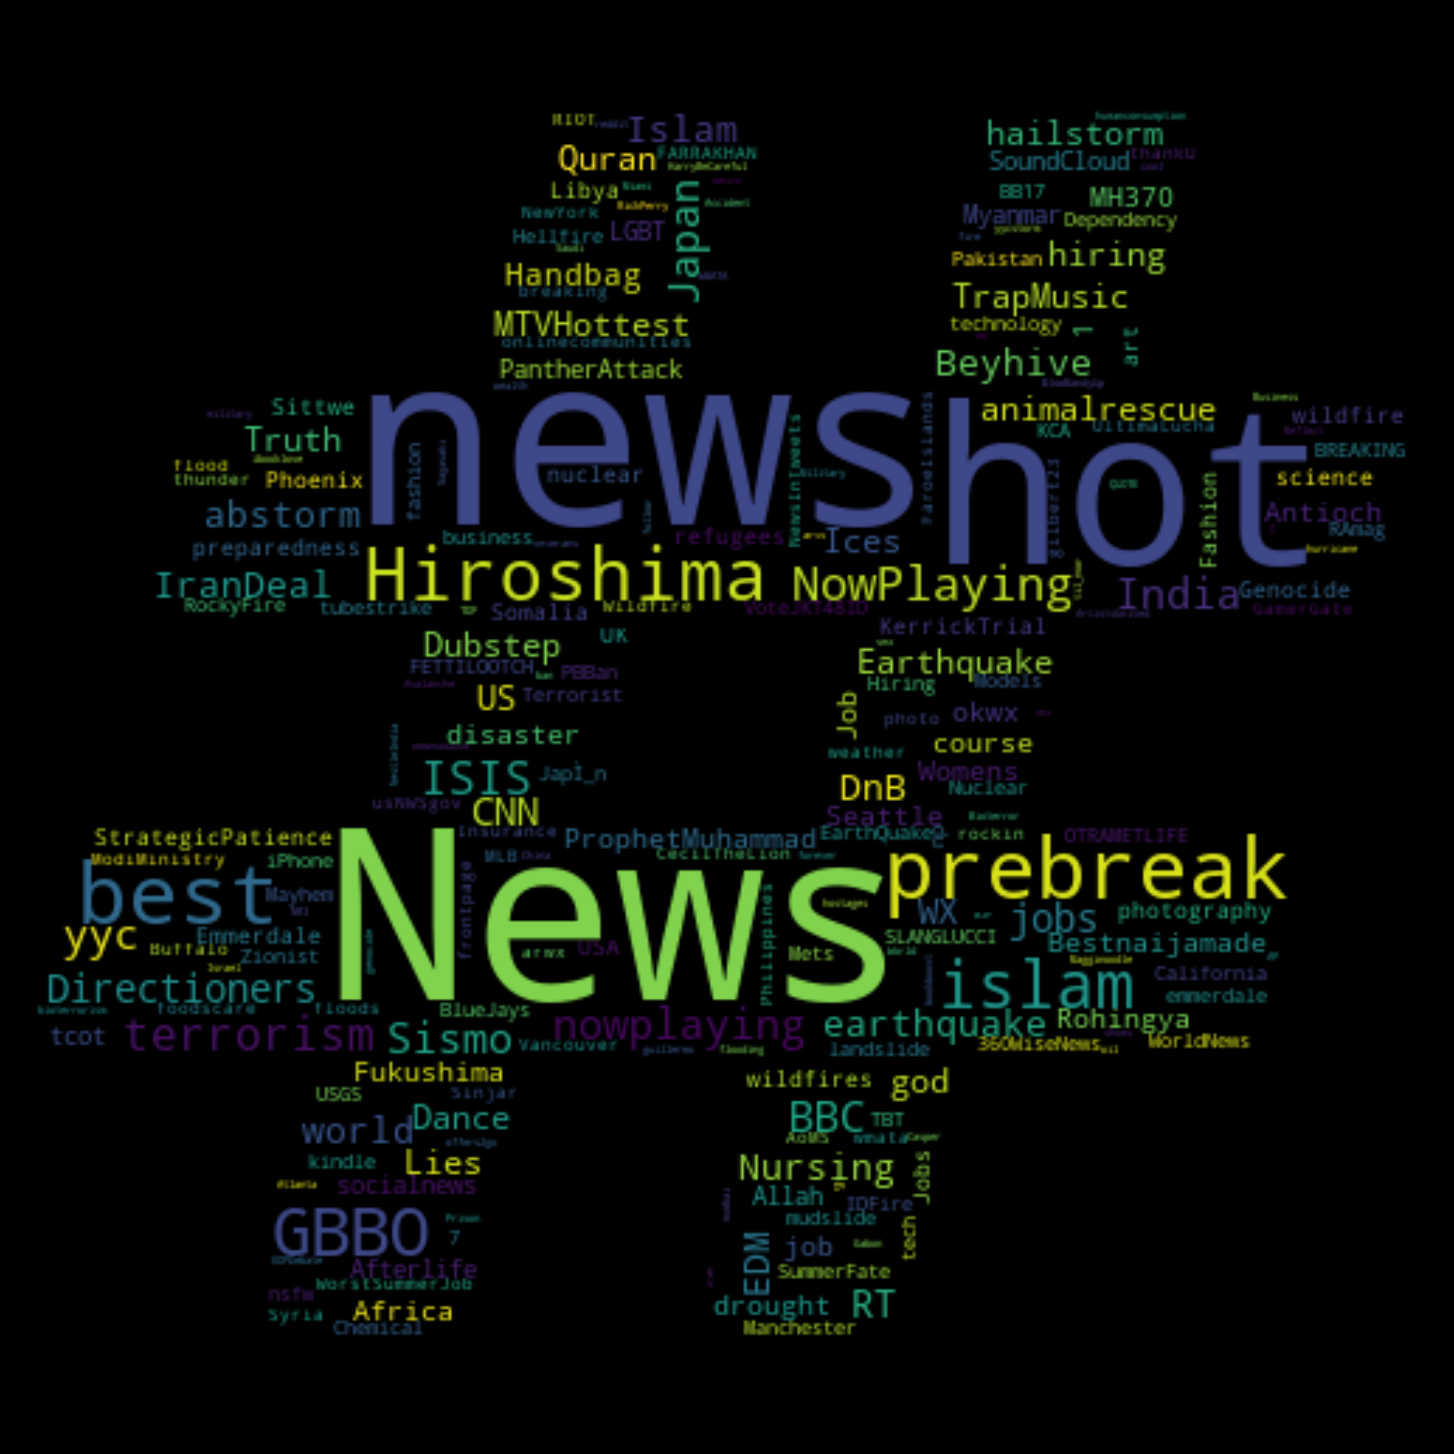

In [32]:
wordcloud = WordCloud(
    width = 400,
    height = 400,
    background_color = 'black',
    max_words = 900,
    mask=transformed_ht_mask).generate_from_frequencies(df_tot_to_dict_for_wc)
fig = plt.figure(
    figsize = (30, 20),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Como news es predominante voy a hacer otro definitivo con todo en minusculas para mayor claridad

## Hashtags (removiendo las mayusculas para juntarlos)

In [33]:
def to_lowercase(x):
    return x.lower()

In [34]:
df_ht['h1'] = df_ht['h1'].apply(to_lowercase)
df_ht['h2'] = df_ht['h2'].apply(to_lowercase)
df_ht['h3'] = df_ht['h3'].apply(to_lowercase)
df_ht['h4'] = df_ht['h4'].apply(to_lowercase)
df_ht['h5'] = df_ht['h5'].apply(to_lowercase)
df_ht['h6'] = df_ht['h6'].apply(to_lowercase)
df_ht['h7'] = df_ht['h7'].apply(to_lowercase)
df_ht['h8'] = df_ht['h8'].apply(to_lowercase)
df_ht['h9'] = df_ht['h9'].apply(to_lowercase)
df_ht['h10'] = df_ht['h10'].apply(to_lowercase)
df_ht['h11'] = df_ht['h11'].apply(to_lowercase)
df_ht['h12'] = df_ht['h12'].apply(to_lowercase)
df_ht['h13'] = df_ht['h13'].apply(to_lowercase)

In [35]:
#dropeo la row 0 que es None
df_ht_1 = df_ht.h1.value_counts().rename_axis('unique_values').reset_index(name='counts').drop(0)
df_ht_2 = df_ht.h2.value_counts().rename_axis('unique_values').reset_index(name='counts').drop(0)
df_ht_3 = df_ht.h3.value_counts().rename_axis('unique_values').reset_index(name='counts').drop(0)
df_ht_4 = df_ht.h4.value_counts().rename_axis('unique_values').reset_index(name='counts').drop(0)
df_ht_5 = df_ht.h5.value_counts().rename_axis('unique_values').reset_index(name='counts').drop(0)
df_ht_6 = df_ht.h6.value_counts().rename_axis('unique_values').reset_index(name='counts').drop(0)
df_ht_7 = df_ht.h7.value_counts().rename_axis('unique_values').reset_index(name='counts').drop(0)
df_ht_8 = df_ht.h8.value_counts().rename_axis('unique_values').reset_index(name='counts').drop(0)
df_ht_9 = df_ht.h9.value_counts().rename_axis('unique_values').reset_index(name='counts').drop(0)
df_ht_10 = df_ht.h10.value_counts().rename_axis('unique_values').reset_index(name='counts').drop(0)
df_ht_11 = df_ht.h11.value_counts().rename_axis('unique_values').reset_index(name='counts').drop(0)
df_ht_12 = df_ht.h12.value_counts().rename_axis('unique_values').reset_index(name='counts').drop(0)
df_ht_13 = df_ht.h13.value_counts().rename_axis('unique_values').reset_index(name='counts').drop(0)

In [36]:
df_tot = df_ht_1.merge(df_ht_2,on='unique_values',how='outer').merge(df_ht_3,on='unique_values',how='outer')\
.merge(df_ht_4,on='unique_values',how='outer').merge(df_ht_5,on='unique_values',how='outer')\
.merge(df_ht_6,on='unique_values',how='outer').merge(df_ht_7,on='unique_values',how='outer')\
.merge(df_ht_8,on='unique_values',how='outer').merge(df_ht_9,on='unique_values',how='outer')\
.merge(df_ht_10,on='unique_values',how='outer').merge(df_ht_11,on='unique_values',how='outer')\
.merge(df_ht_12,on='unique_values',how='outer').merge(df_ht_13,on='unique_values',how='outer')

In [37]:
df_tot.head(5)

unique_values  counts_x  counts_y  counts_x  counts_y  counts_x  counts_y  \
0          news      37.0      32.0       3.0       1.0       NaN       NaN   
1           hot      31.0       NaN       NaN       NaN       NaN       NaN   
2    nowplaying      20.0       2.0       NaN       1.0       NaN       NaN   
3    earthquake      19.0       NaN       NaN       NaN       NaN       NaN   
4     hiroshima      17.0       4.0       NaN       1.0       NaN       NaN   

   counts_x  counts_y  counts_x  counts_y  counts_x  counts_y  counts  
0       NaN       NaN       NaN       3.0       NaN       NaN     NaN  
1       NaN       NaN       NaN       NaN       NaN       NaN     NaN  
2       NaN       NaN       NaN       NaN       NaN       NaN     NaN  
3       NaN       NaN       NaN       NaN       NaN       NaN     NaN  
4       NaN       NaN       NaN       NaN       NaN       NaN     NaN

In [38]:
df_tot['total_count'] = df_tot.sum(axis=1) 

In [39]:
df_tot = df_tot[['unique_values','total_count']]

In [40]:
df_tot.head(5)

unique_values  total_count
0          news         76.0
1           hot         31.0
2    nowplaying         23.0
3    earthquake         19.0
4     hiroshima         22.0

In [41]:
df_tot.shape

(1926, 2)

In [42]:
df_tot_to_dict_for_wc = pd.Series(df_tot.total_count.values,index=df_tot.unique_values).to_dict()

## Wordcloud asumiendo que para cada hashtag no se tiene en cuenta la diferencia entre mayusculas

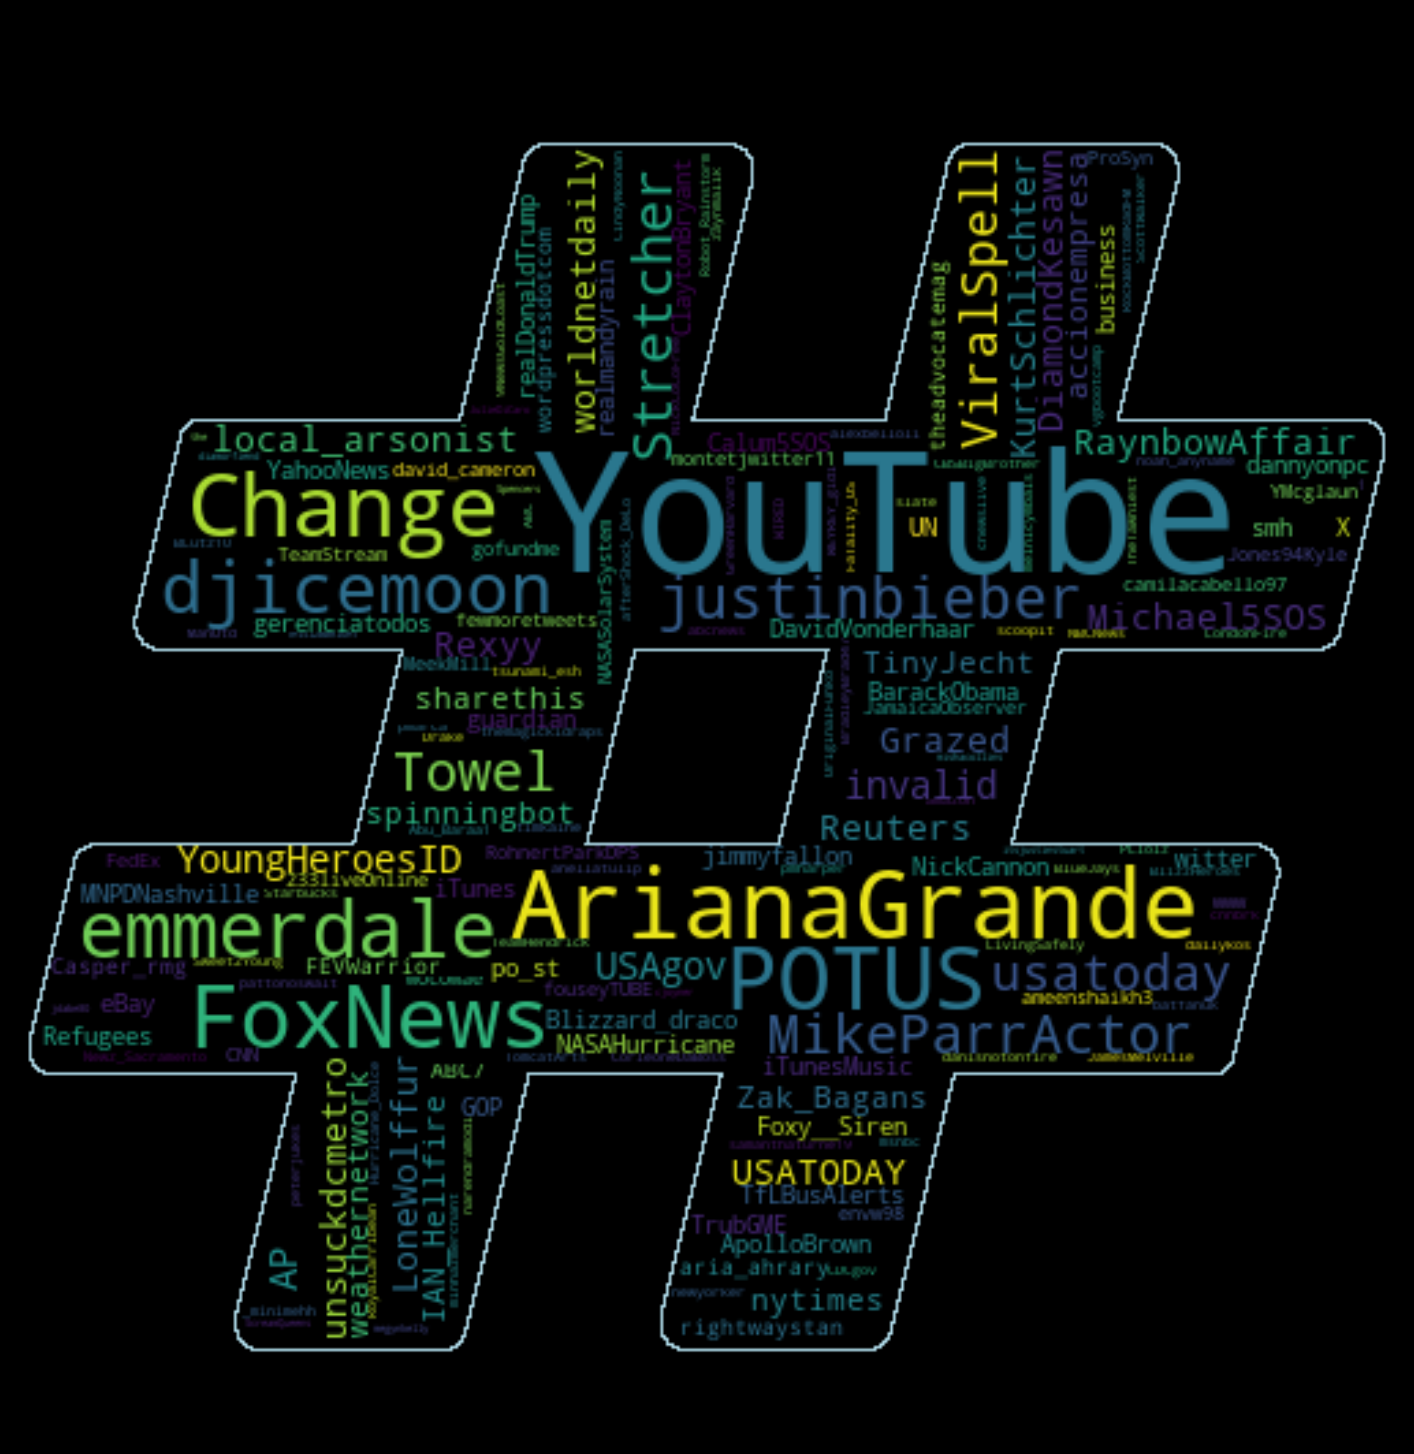

In [72]:
wordcloud = WordCloud(
    width = 400,
    height = 400,
    contour_width=0.5,
    contour_color='lightblue',
    background_color = 'black',
    max_words=900,
    mask=transformed_ht_mask).generate_from_frequencies(df_tot_to_dict_for_wc)
fig = plt.figure(
    figsize = (30, 20),
    facecolor = 'k',
    edgecolor = 'k')
plt.title("Wordcloud frecuencia de hashtags",size=40)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
if savefigs:
    plt.savefig('figs/ht_wc.png', bbox_inches='tight')
plt.show()

## Tags (unicos)

In [51]:
def extract_tags(x):
    return re.findall(r'@\w+', x)

In [52]:
df['tags'] = df['text'].apply(extract_tags)
df['tags_len'] = df['tags'].apply(get_list_length)

In [53]:
df['tags_len'].max()

8

In [54]:
t_list = ['t1','t2','t3','t4','t5','t6','t7','t8']

In [55]:
df_t = pd.DataFrame(df.tags.tolist(), index= df.index,columns=t_list)

In [56]:
def remove_t(x):
    return re.sub('@', '', x)

In [57]:
df_t = df_t.astype(str)

In [58]:
df_t['t1'] = df_t['t1'].apply(remove_t)
df_t['t2'] = df_t['t2'].apply(remove_t)
df_t['t3'] = df_t['t3'].apply(remove_t)
df_t['t4'] = df_t['t4'].apply(remove_t)
df_t['t5'] = df_t['t5'].apply(remove_t)
df_t['t6'] = df_t['t6'].apply(remove_t)
df_t['t7'] = df_t['t7'].apply(remove_t)
df_t['t8'] = df_t['t8'].apply(remove_t)

In [59]:
#dropeo la row 0 que es None
df_t_1 = df_t.t1.value_counts().rename_axis('unique_values').reset_index(name='counts').drop(0)
df_t_2 = df_t.t2.value_counts().rename_axis('unique_values').reset_index(name='counts').drop(0)
df_t_3 = df_t.t3.value_counts().rename_axis('unique_values').reset_index(name='counts').drop(0)
df_t_4 = df_t.t4.value_counts().rename_axis('unique_values').reset_index(name='counts').drop(0)
df_t_5 = df_t.t5.value_counts().rename_axis('unique_values').reset_index(name='counts').drop(0)
df_t_6 = df_t.t6.value_counts().rename_axis('unique_values').reset_index(name='counts').drop(0)
df_t_7 = df_t.t7.value_counts().rename_axis('unique_values').reset_index(name='counts').drop(0)
df_t_8 = df_t.t8.value_counts().rename_axis('unique_values').reset_index(name='counts').drop(0)

In [60]:
df_tot = df_t_1.merge(df_t_2,on='unique_values',how='outer').merge(df_t_3,on='unique_values',how='outer')\
.merge(df_t_4,on='unique_values',how='outer').merge(df_t_5,on='unique_values',how='outer')\
.merge(df_t_6,on='unique_values',how='outer').merge(df_t_7,on='unique_values',how='outer')\
.merge(df_t_8,on='unique_values',how='outer')

In [61]:
df_tot.head(5)

unique_values  counts_x  counts_y  counts_x  counts_y  counts_x  counts_y  \
0       YouTube      80.0       2.0       NaN       NaN       NaN       NaN   
1        Change       9.0       NaN       NaN       NaN       NaN       NaN   
2  ArianaGrande       7.0       4.0       NaN       NaN       NaN       NaN   
3     emmerdale       7.0       1.0       NaN       NaN       NaN       NaN   
4     djicemoon       7.0       NaN       NaN       NaN       NaN       NaN   

   counts_x  counts_y  
0       NaN       NaN  
1       NaN       NaN  
2       NaN       NaN  
3       NaN       NaN  
4       NaN       NaN

In [62]:
df_tot['total_count'] = df_tot.sum(axis=1) 

In [63]:
df_tot = df_tot[['unique_values','total_count']]

In [64]:
df_tot.head(5)

unique_values  total_count
0       YouTube         82.0
1        Change          9.0
2  ArianaGrande         11.0
3     emmerdale          8.0
4     djicemoon          7.0

In [65]:
df_tot.shape

(2326, 2)

In [66]:
df_tot_to_dict_for_wc = pd.Series(df_tot.total_count.values,index=df_tot.unique_values).to_dict()

In [67]:
d = getcwd()
t_mask = np.array(Image.open(path.join(d, "imgforwc/tag.png")))

## Wordcloud asumiendo que cada hashtag es unico y se tiene en cuenta la diferencia entre mayusculas

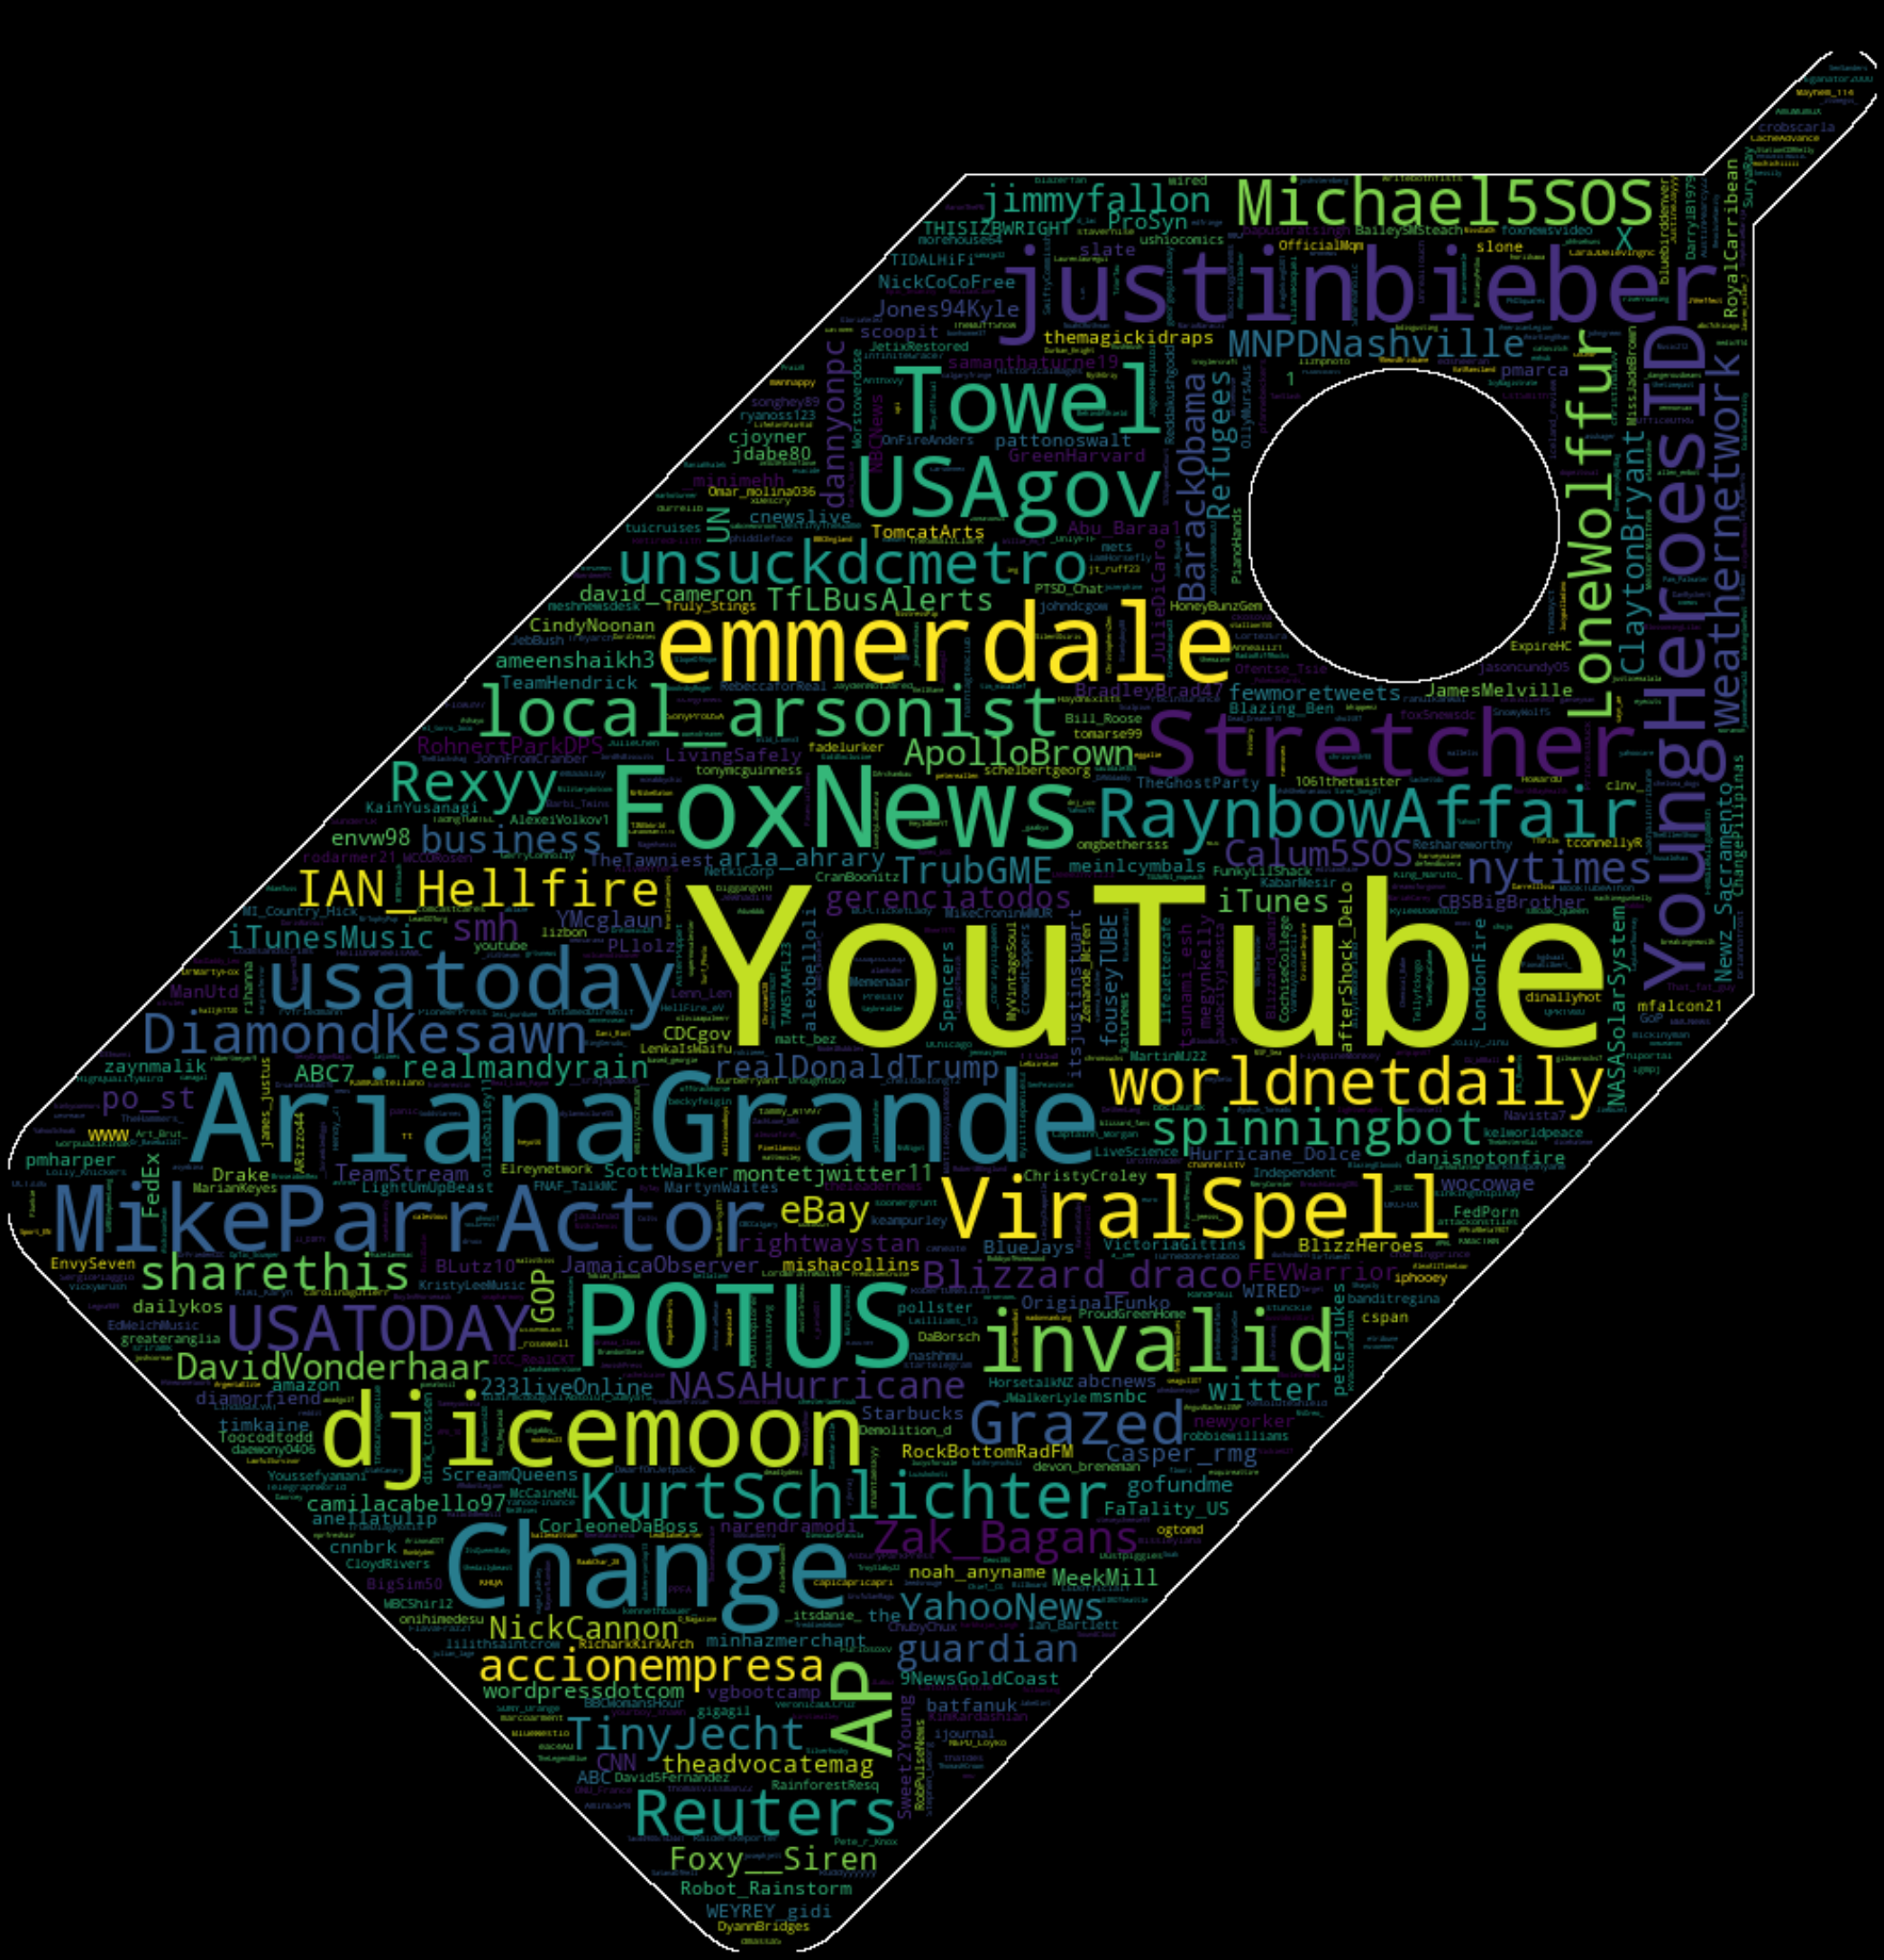

In [71]:
wordcloud = WordCloud(
    width = 400,
    height = 400,
    contour_width=0.5,
    contour_color='white',
    background_color = 'black',
    max_words = 1000,
    mask=t_mask).generate_from_frequencies(df_tot_to_dict_for_wc)
fig = plt.figure(
    figsize = (30,30),
    facecolor = 'k',
    edgecolor = 'k')
plt.title("Wordcloud frecuencia de etiquetas",size=50)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
if savefigs:
    plt.savefig('figs/t_wc.png', bbox_inches='tight')
plt.show()

## Referencias a links (unicos)

In [130]:
def extract_tweets(x):
    return re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', x)

In [131]:
df['tweet'] = df['text'].apply(extract_tweets)
df['tweet_len'] = df['tweet'].apply(get_list_length)

In [132]:
df['tweet_len'].max()

4

In [133]:
tw_list = ['tw1','tw2','tw3','tw4']

In [134]:
df_tw = pd.DataFrame(df.tweet.tolist(), index= df.index,columns=tw_list)

In [135]:
df_tw = df_tw.astype(str)

In [136]:
def remove_tw_link(x):
    return re.sub('http://', '', x)

In [137]:
df_tw['tw1'] = df_tw['tw1'].apply(remove_tw_link)
df_tw['tw2'] = df_tw['tw2'].apply(remove_tw_link)
df_tw['tw3'] = df_tw['tw3'].apply(remove_tw_link)
df_tw['tw4'] = df_tw['tw4'].apply(remove_tw_link)

In [138]:
#dropeo la row 0 que es None
df_tw_1 = df_tw.tw1.value_counts().rename_axis('unique_values').reset_index(name='counts').drop(0)
df_tw_2 = df_tw.tw2.value_counts().rename_axis('unique_values').reset_index(name='counts').drop(0)
df_tw_3 = df_tw.tw3.value_counts().rename_axis('unique_values').reset_index(name='counts').drop(0)
df_tw_4 = df_tw.tw4.value_counts().rename_axis('unique_values').reset_index(name='counts').drop(0)

In [139]:
df_tot = df_tw_1.merge(df_tw_2,on='unique_values',how='outer').merge(df_tw_3,on='unique_values',how='outer')\
.merge(df_tw_4,on='unique_values',how='outer')

In [140]:
df_tot.head(5)

unique_values  counts_x  counts_y  counts_x  counts_y
0  t.co/qew4c5M1xd       9.0       NaN       NaN       NaN
1  t.co/q2eBlOKeVE       6.0       NaN       NaN       NaN
2  t.co/KSAwlYuX02       6.0       NaN       NaN       NaN
3  t.co/cybKsXHF7d       5.0       NaN       NaN       NaN
4  t.co/vVPLFQv58P       5.0       NaN       NaN       NaN

In [141]:
df_tot['total_count'] = df_tot.sum(axis=1) 

In [142]:
df_tot = df_tot[['unique_values','total_count']]

In [143]:
df_tot.head(5)

unique_values  total_count
0  t.co/qew4c5M1xd          9.0
1  t.co/q2eBlOKeVE          6.0
2  t.co/KSAwlYuX02          6.0
3  t.co/cybKsXHF7d          5.0
4  t.co/vVPLFQv58P          5.0

In [144]:
df_tot_top6 = df_tot.nlargest(6, 'total_count')

In [145]:
df_tot_top6

unique_values  total_count
0     t.co/qew4c5M1xd          9.0
1     t.co/q2eBlOKeVE          6.0
2     t.co/KSAwlYuX02          6.0
3875  t.co/eNCmhz6y34          6.0
3     t.co/cybKsXHF7d          5.0
4     t.co/vVPLFQv58P          5.0

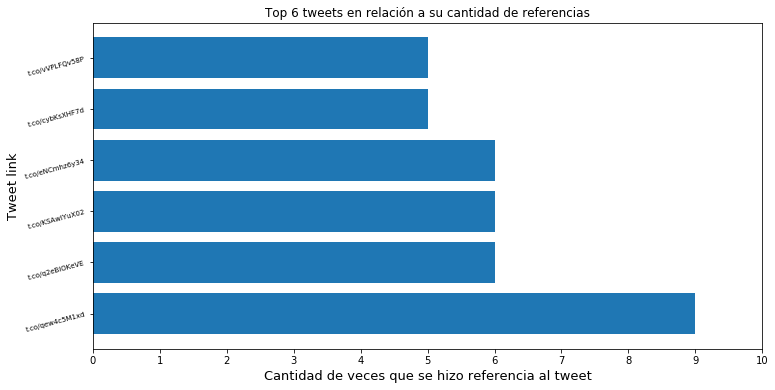

In [149]:
plt.figure(figsize=(12,6))
plt.barh(df_tot_top6.unique_values, df_tot_top6.total_count, align='center')
plt.yticks(fontsize=7,rotation=15)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10])
plt.xlabel('Cantidad de veces que se hizo referencia al tweet',fontsize=13)
plt.ylabel('Tweet link',fontsize=13)
plt.title('Top 6 tweets en relación a su cantidad de referencias')
if savefigs:
    plt.savefig('figs/top6links.png', bbox_inches='tight')
plt.show()

## Links interesantes de aca relacionados al tema
### [Tweet mas visitado - Como prepararse para un tornado](https://t.co/qew4c5M1xd)
### [Tweet de video de youtube de tsunamis y terremotos](https://t.co/cybKsXHF7d)

#### [Offtopic: Fotos de busqueda del llamado Escuadron 731 en coreano](https://t.co/vVPLFQv58P)

# Recupero los valores de location para los paises

In [3]:
geolocator = Nominatim(user_agent="datos")

In [4]:
df_l = pd.read_csv('data/train.csv')

In [5]:
df_l = df_l[df_l['location'].notna()]

In [6]:
def find_countries(x):
    if((x) is not None):
        address = x.raw['address']
        country = address.get('country', '')
        address100 = address.get('address100', '')
        if(country != ''):
            return country
        elif (address100 != ''):
            return address100
    else:
        return np.NaN

In [7]:
from functools import partial


In [10]:
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

In [ ]:
from tqdm import tqdm
tqdm.pandas()
df_l['asd'] = df_l['location'].progress_apply(partial(geocode,language='en',addressdetails=True))

100%|██████████| 5080/5080 [2:50:59<00:00,  2.02s/it]

In [12]:
df_l['asd_2'] = df_l['asd'].apply(find_countries)

In [ ]:
df_l.to_csv('df_countries.csv')

# Filtro la basura (dejando un poco de ruido) de los paises que haya encontrado la libreria

In [401]:
df_locations = pd.read_csv("df_countries.csv")

In [402]:
df_locations = df_locations.rename(columns={'asd_2': 'country'})

In [403]:
df_locations = df_locations[['id','location','country']]

In [404]:
df_locations.loc[df_locations['country'] == 'Chad']

id location country
4291  9109  Gidi     Chad

### Lista de valores que deberian ser removidos/cambiados

### Por indice

Switzerland (index = 2805, 789, 893, 270) = 
Sweden (index = 3994, 3634, 946) =
Dominican Republic (index = 457, 2949, 2951, 3633, 3851, 4563, 4969) = 
Malaysia (index = 1943) =
Singapore (index = 4492, 1956, 548 ,211) =
Ethiopia (index = 4129, 4069, 1343, 1342) =
Russia (index = 1259, 149, 757) =
Portugal (index = 4776, 2606, 2492, 720, 319) =
United Arab Emirates (index = 2602,1429) = 
Peru (index = 5048,5044,1529) =
Thailand (index = 4159,4154,2324) =
Egypt (index = 4111) =
Mexico (index = 654) =
Colombia (index = 1560) = 
Venezuela (index = 4829,4783,2466) =
Saudi Arabia (index = 698,1408) = 
Bulgaria (index = 2587) = 
Sierra Leone (index = 2529) = 
Cuba (index = 135) = 
Bangladesh (index = 1998) = 
Costa Rica (index = 4206) =
Morocco (index = 3171) =
Morocco (index = 5066) =
Hungary (index = 4232) =
Iraq (index = 1603) =
Turkey (index = 1086) = 
South Korea (index = 844) = 
Greece (index = 1847) =
Belgium (index = 670, 4651) = 
Ghana (index = 492) =
Vietnam (index = 1810, 2029) =
Ukraine (index = 1580) =
Laos (index = 1095) = 

Ecuador (index = 4795) = USA
Chile (index = 3321, 3471) = USA
Jersey (index = 568) = USA
Sweden (index = 3397) = UK
Sierra Leone (index = 4211) = USA 
Egypt (index = 2601,2475,2241,1610) = USA
Colombia (index = 847,1642,4138) = USA
Venezuela (index = 4802) = USA

Como USA y UK son predominantes saco directamente los indices que correspondian a otro pais

### A remover segun indice

In [405]:
to_remove = [1095,2805, 789, 893, 270,3994, 3634, 946,457, 2949, 2951, 3633, 3851, 4563, 4969,1943,4492, 1956, 548 ,211,\
            4129, 4069, 1343, 1342, 1259, 149, 757, 4776, 2606, 2492, 720, 319, 2602, 1429, 5048,5044,1529,\
            4159,4154,2324,4111,654,1560,4829,4783,2466,698,1408,2587,2529,135,1998,4206,3171,5066,4232,1603,1086,\
            844,1847,670, 4651,492,1810, 2029,1580,4795,3321,3471,568,3397,4211,2601,2475,2241,1610,847,1642,4138,4802]

In [406]:
df_locations = df_locations.drop(to_remove)

### A reemplazar

Chad = India 
Albania = UK
Jersey = Francia
Laos = Nigeria
Panama = USA
Moldova = USA
Togo = USA 
Azerbaijan = USA 
Ethiopia = USA
Tunisia = USA

In [407]:
df_locations['country'].replace('Chad', 'India',inplace=True)
df_locations['country'].replace('United States of America', 'United States',inplace=True)
df_locations['country'].replace('Albania', 'United Kingdom',inplace=True)
df_locations['country'].replace('Jersey', 'Francia',inplace=True)
df_locations['country'].replace('Laos', 'Nigeria',inplace=True)
df_locations['country'].replace('Panama', 'United States',inplace=True)
df_locations['country'].replace('Moldova', 'United States',inplace=True)
df_locations['country'].replace('Togo', 'United States',inplace=True)
df_locations['country'].replace('Azerbaijan', 'United States',inplace=True)
df_locations['country'].replace('Ethiopia', 'United States',inplace=True)
df_locations['country'].replace('Tunisia', 'United States',inplace=True)

### A remover

Nepal
Tanzania
Macedonia
Guernsey 
South Sudan
Cambodia
Estonia
North America
Austria
Bosnia and Herzegovina
Uruguay 
Malawi 
Armenia 
Europe
Belarus 
Asia
Liberia
Haiti
Democratic Republic of the Congo
Iran 
Czech Republic 

In [408]:
df_locations = df_locations.loc[df_locations['country'] != 'Nepal']
df_locations = df_locations.loc[df_locations['country'] != 'Tanzania']
df_locations = df_locations.loc[df_locations['country'] != 'Macedonia']
df_locations = df_locations.loc[df_locations['country'] != 'South Sudan']
df_locations = df_locations.loc[df_locations['country'] != 'Cambodia']
df_locations = df_locations.loc[df_locations['country'] != 'Estonia']
df_locations = df_locations.loc[df_locations['country'] != 'North America']
df_locations = df_locations.loc[df_locations['country'] != 'Austria']
df_locations = df_locations.loc[df_locations['country'] != 'Bosnia and Herzegovina']
df_locations = df_locations.loc[df_locations['country'] != 'Uruguay']
df_locations = df_locations.loc[df_locations['country'] != 'Malawi']
df_locations = df_locations.loc[df_locations['country'] != 'Armenia']
df_locations = df_locations.loc[df_locations['country'] != 'Europe']
df_locations = df_locations.loc[df_locations['country'] != 'Belarus']
df_locations = df_locations.loc[df_locations['country'] != 'Asia']
df_locations = df_locations.loc[df_locations['country'] != 'Liberia']
df_locations = df_locations.loc[df_locations['country'] != 'Haiti']
df_locations = df_locations.loc[df_locations['country'] != 'Democratic Republic of the Congo']
df_locations = df_locations.loc[df_locations['country'] != 'Iran']
df_locations = df_locations.loc[df_locations['country'] != 'Czech Republic ']

### Lista de ciertas palabras en las filas que deberian hacer que se remueva la row para reducir un poco el ruido

worldwide, world wide, the world, world, 304, 434, the dark, milky way, god is love., america, 518, the grey area, keli x, multinational, everywhere, 302, ss, narnia, in my studio, in the word of god, here and there, somewhere, planet earth, global, The Universe, The North, North, Incognito

In [409]:
df_locations['location'] = df_locations['location'].str.lower()

In [410]:
df_locations = df_locations.loc[df_locations['location'] != 'worldwide']
df_locations = df_locations.loc[df_locations['location'] != 'world wide']
df_locations = df_locations.loc[df_locations['location'] != 'the world']
df_locations = df_locations.loc[df_locations['location'] != 'world']
df_locations = df_locations.loc[df_locations['location'] != '304']
df_locations = df_locations.loc[df_locations['location'] != '434']
df_locations = df_locations.loc[df_locations['location'] != 'the dark']
df_locations = df_locations.loc[df_locations['location'] != 'milky way']
df_locations = df_locations.loc[df_locations['location'] != 'god is love.']
df_locations = df_locations.loc[df_locations['location'] != 'america']
df_locations = df_locations.loc[df_locations['location'] != '518']
df_locations = df_locations.loc[df_locations['location'] != 'the grey area']
df_locations = df_locations.loc[df_locations['location'] != 'keli x']
df_locations = df_locations.loc[df_locations['location'] != 'multinational']
df_locations = df_locations.loc[df_locations['location'] != 'everywhere']
df_locations = df_locations.loc[df_locations['location'] != '302']
df_locations = df_locations.loc[df_locations['location'] != 'ss']
df_locations = df_locations.loc[df_locations['location'] != 'narnia']
df_locations = df_locations.loc[df_locations['location'] != 'in my studio']
df_locations = df_locations.loc[df_locations['location'] != 'in the word of god']
df_locations = df_locations.loc[df_locations['location'] != 'here and there']
df_locations = df_locations.loc[df_locations['location'] != 'somewhere']
df_locations = df_locations.loc[df_locations['location'] != 'planet earth']
df_locations = df_locations.loc[df_locations['location'] != 'global']
df_locations = df_locations.loc[df_locations['location'] != 'the universe']
df_locations = df_locations.loc[df_locations['location'] != 'the north']
df_locations = df_locations.loc[df_locations['location'] != 'north']
df_locations = df_locations.loc[df_locations['location'] != 'incognito']

Dropeo naNs

In [411]:
df_locations = df_locations[['id','country']]

In [412]:
df_locations = df_locations[df_locations['country'].notna()]

In [418]:
#df_locations.to_csv('df_countries.csv')

## Barplot de tweets en paises/region para chequear luego que sea consistente lo que la libreria encontro en los paises

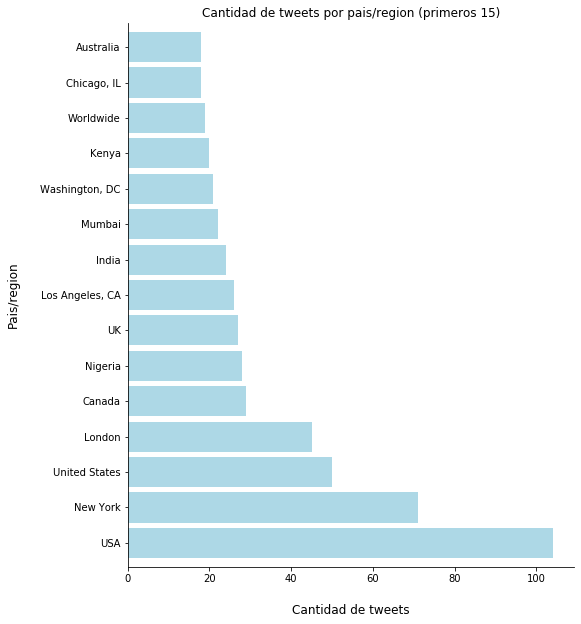

In [89]:
df_locat_count = df['location'].value_counts()
df_locat_count.reset_index()
df_locat_count = df_locat_count[:15,]

ax = df_locat_count.plot(kind='barh', figsize=(8, 10), color='LightBlue', zorder=2, width=0.85,title ='Cantidad de tweets por pais/region (primeros 15)')

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Set x-axis label
ax.set_xlabel("Cantidad de tweets", labelpad=20, size=12)

# Set y-axis label
ax.set_ylabel("Pais/region", labelpad=20, size=12)
plt.show()

## Cloropleth de los paises

In [5]:
df_locations = pd.read_csv('df_countries.csv',usecols=['id','country'])

In [6]:
df_locations.country.replace({'The Netherlands': 'Netherlands','Czech Republic':'Czechia',\
                             'Russia':'Russian Federation','Vietnam':'Viet Nam',\
                             'Jamaika':'Jamaica','Francia':'France',\
                             'Syria':'Syrian Arab Republic','Palestinian Territory':'Palestine, State of',\
                             'Africa':'Central African Republic'},inplace=True)

In [7]:
def extract_codes(x):
    country_data = pycountry.countries.get(name=x)
    if(country_data != None):
        return country_data.alpha_3

In [8]:
df_locations['code'] = df_locations['country'].apply(extract_codes)

In [9]:
df_locations['code'] = df_locations['code'].astype(str)

In [10]:
df_locations['code'] = np.where((df_locations['country'] == 'Venezuela'),
                           'VEN',      
                           df_locations['code']) 

In [11]:
df_locations['code'] = np.where((df_locations['country'] == 'South Korea'),
                           'PRK',      
                           df_locations['code']) 

In [12]:
df_locations_cloropleth = df_locations.groupby(['country','code']).size().reset_index(name='tweet_count')

In [13]:
df_locations_cloropleth['tweet_log_count'] = np.log(df_locations_cloropleth['tweet_count'])

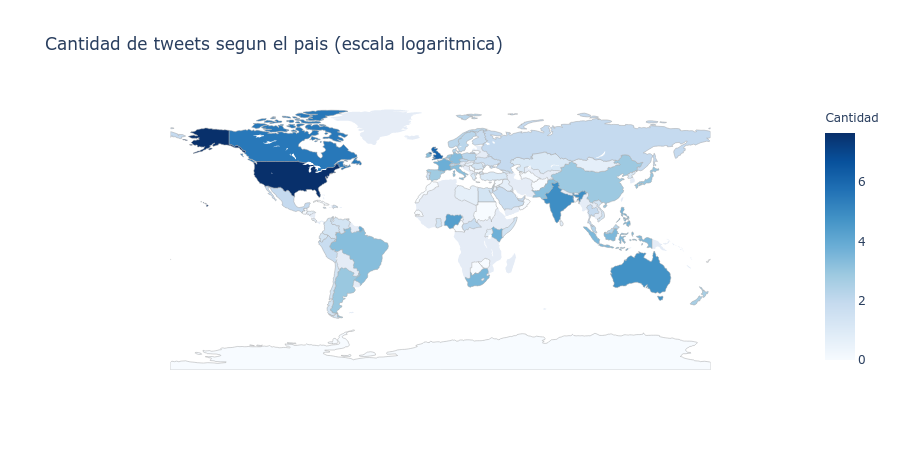

In [81]:
fig = go.Figure(data=go.Choropleth(
    locations = df_locations_cloropleth['code'],
    z = df_locations_cloropleth['tweet_log_count'],
    text = df_locations_cloropleth['country'],
    colorscale = 'Blues',
    autocolorscale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_title = 'Cantidad',
))

fig.update_layout(
    title_text='Cantidad de tweets segun el pais (escala logaritmica)',
    yaxis_type="log",
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    )
)

fig.show()

# Barplot segun target para location

In [17]:
df_locations = pd.read_csv('df_countries.csv',usecols=['id','country'])

In [18]:
df_locations.shape

(3840, 2)

In [19]:
df_with_location = pd.merge(df,df_locations,how='left',on='id')

In [20]:
df_with_location_target_1 = df_with_location.loc[df_with_location["target"]==1]
df_with_location_target_1_count = np.log(df_with_location_target_1['country'].value_counts()).reset_index()

In [21]:
df_with_location_target_0 = df_with_location.loc[df_with_location["target"]==0]
df_with_location_target_0_count = np.log(df_with_location_target_0['country'].value_counts()).reset_index()

In [22]:
location_count = pd.merge(df_with_location_target_0_count,df_with_location_target_1_count,how='inner',on='index')
location_count.rename(columns = {'country_x':'No Real', 'country_y':'Real'}, inplace = True)
location_count = location_count[:20]

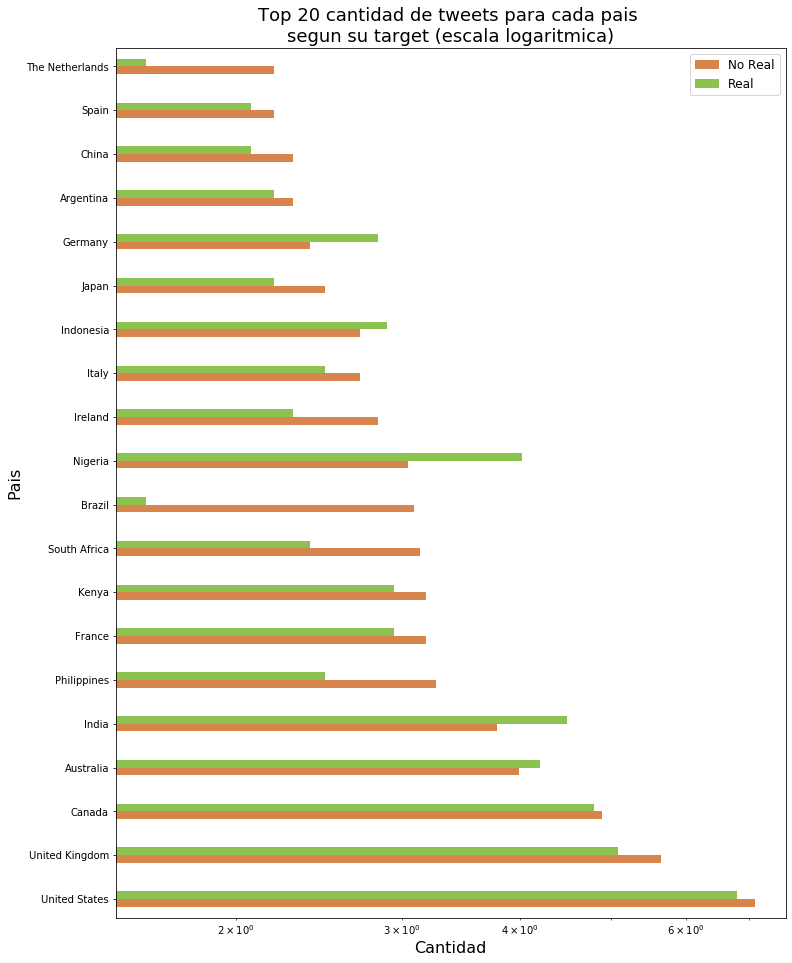

In [83]:
location_count.plot(logx=True,
    x="index", y=["No Real", "Real"], kind="barh",figsize=(12,16),width=0.35,color=('#c65102','#5ca904'),alpha=0.7
)
plt.title("Top 20 cantidad de tweets para cada pais \nsegun su target (escala logaritmica)",size=18)
plt.xlabel("Cantidad",size=16)
plt.ylabel("Pais",size=16)
plt.legend(prop={'size': 12})
if savefigs:
    plt.savefig('figs/top_paises.png', bbox_inches='tight')
plt.show()

# Analisis de texto

In [26]:
def separate_words_according_to_target(target):
    words=[]
    
    for x in df[df['target']==target]['text'].str.split():
        for i in x:
            words.append(i)
    return words

In [27]:
words_0=separate_words_according_to_target(0)
words_1=separate_words_according_to_target(1)

## Stopwords

In [28]:
stopwords = set(stopwords.words('english'))

In [29]:
dict_0 = defaultdict(int)
for word in words_0:
    if word.lower() in stopwords:
        dict_0[word.lower()]+=1
        
top_0=sorted(dict_0.items(), key=lambda x:x[1],reverse=True)[:20] 

In [30]:
dict_1 = defaultdict(int)
for word in words_1:
    if word.lower() in stopwords:
        dict_1[word.lower()]+=1
        
top_1=sorted(dict_1.items(), key=lambda x:x[1],reverse=True)[:20] 

In [31]:
top_0_df = pd.DataFrame(top_0,columns=['stopword','quantity'])
top_1_df = pd.DataFrame(top_1,columns=['stopword','quantity'])

In [32]:
top_stopwords = pd.merge(top_0_df,top_1_df,how='inner',on='stopword')
top_stopwords.rename(columns = {'quantity_x':'No Real', 'quantity_y':'Real'}, inplace = True)

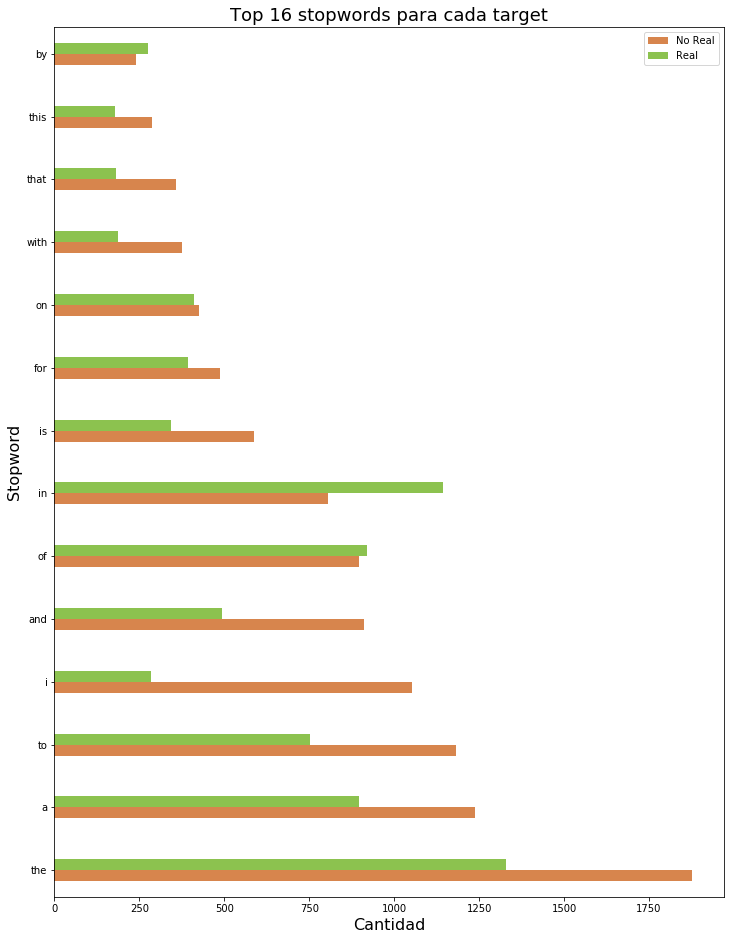

In [33]:
top_stopwords.plot(
    x="stopword", y=["No Real", "Real"], kind="barh",figsize=(12,16),width=0.35,color=('#c65102','#5ca904'),alpha=0.7
)
plt.title("Top 16 stopwords para cada target", size=18)
plt.xlabel("Cantidad",size=16)
plt.ylabel("Stopword",size=16)
if savefigs:
    plt.savefig('figs/top_stopwords.png', bbox_inches='tight')
plt.show()

In [34]:
## Number of stopwords in the text ##
df["num_stopwords"] = df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords]))

In [35]:
df_stopwords = df.copy()

In [36]:
#cambio los valores del target para mayor entendimiento en el grafico
mapping = {0: 'No Real', 1: "Real"}
df_stopwords.replace({'target': mapping},inplace=True)

In [37]:
df_stopwords_red = df_stopwords.loc[:,['num_stopwords','target']]

In [38]:
bin_quant = (max(df_stopwords_red['num_stopwords']) - min(df_stopwords_red['num_stopwords'])) / 1.1
bin_quant = round(bin_quant)

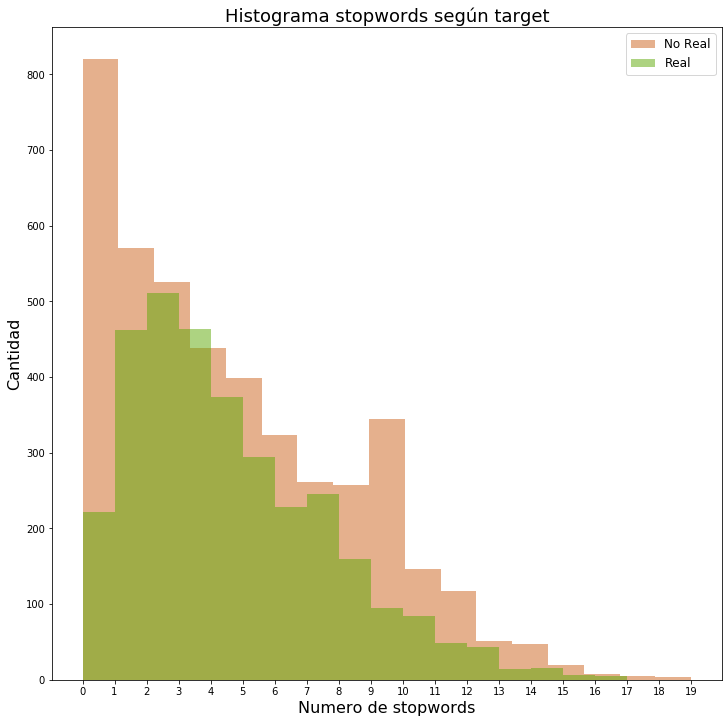

In [39]:
df_plot_1 = df_stopwords_red[df_stopwords_red.target == 'Real']
df_plot_0 =df_stopwords_red[df_stopwords_red.target == 'No Real']
plt.figure(figsize=(12,12))
sns.distplot(df_plot_0['num_stopwords'],  kde=False,label='No Real', bins=bin_quant,
            hist_kws={"alpha": 0.45, "color": "#c65102"})
sns.distplot(df_plot_1['num_stopwords'],  kde=False, label='Real',bins=bin_quant,
            hist_kws={"alpha": 0.5, "color": "#5ca904"})
plt.legend(prop={'size': 12})
plt.title('Histograma stopwords según target',size=18)
plt.xlabel('Numero de stopwords',size=16)
plt.xticks(np.arange(min(df_stopwords_red['num_stopwords']), max(df_stopwords_red['num_stopwords'])+1, 1))
plt.ylabel('Cantidad',size=16)
if savefigs:
    plt.savefig('figs/hist_stopwords.png', bbox_inches='tight')
plt.show()

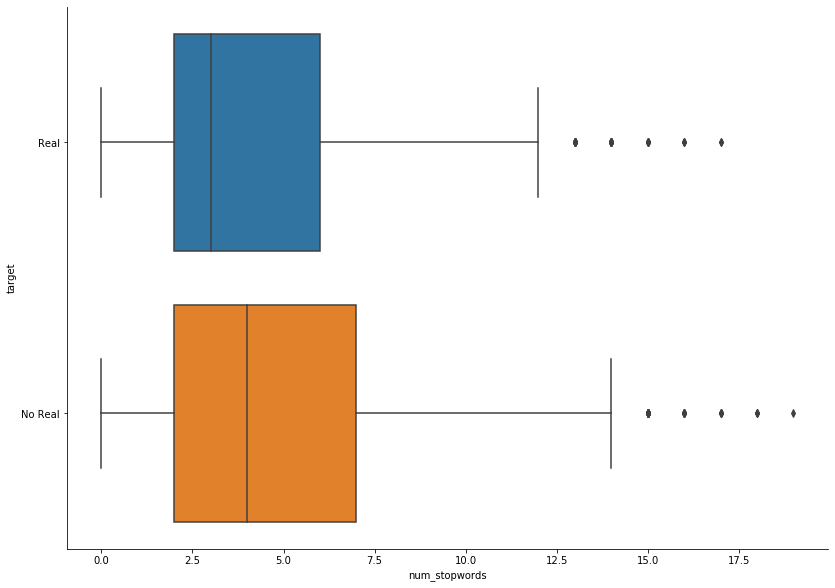

In [40]:
sns.catplot(x="num_stopwords", y="target", kind="box", data=df_stopwords_red,height=8.27, aspect=11.7/8.27);
if savefigs:
    plt.savefig('figs/boxplot_stopw.png', bbox_inches='tight')

## Puntuación

In [41]:
puntuacion = string.punctuation

In [42]:
dict_0 = defaultdict(int)
for word in words_0:
    if word in puntuacion:
        dict_0[word]+=1
        
top_0=sorted(dict_0.items(), key=lambda x:x[1],reverse=True)[:20] 

In [43]:
dict_1 = defaultdict(int)
for word in words_1:
    if word in puntuacion:
        dict_1[word]+=1
        
top_1=sorted(dict_1.items(), key=lambda x:x[1],reverse=True)[:20] 

In [44]:
top_0_df = pd.DataFrame(top_0,columns=['puntuacion','quantity'])
top_1_df = pd.DataFrame(top_1,columns=['puntuacion','quantity'])

top_0_df['quantity'] = np.log(top_0_df['quantity'])
top_1_df['quantity'] = np.log(top_1_df['quantity'])

In [45]:
top_puntuacion = pd.merge(top_0_df,top_1_df,how='inner',on='puntuacion')
top_puntuacion.rename(columns = {'quantity_x':'No Real', 'quantity_y':'Real'}, inplace = True)

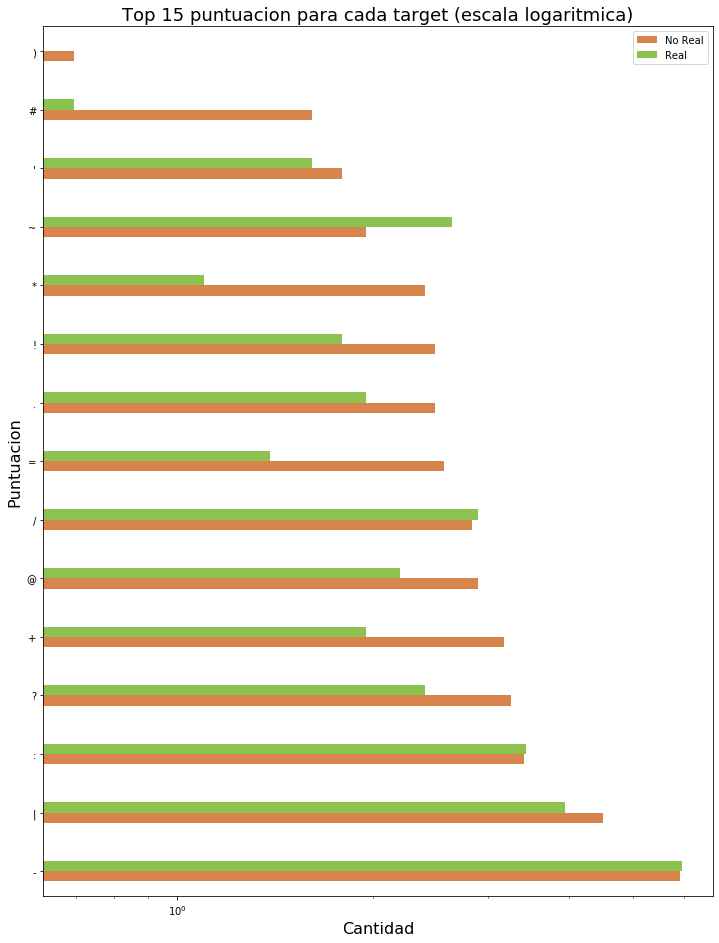

In [92]:
top_puntuacion.plot(logx=True,
    x="puntuacion", y=["No Real", "Real"], kind="barh",figsize=(12,16),width=0.35,color=('#c65102','#5ca904'),alpha=0.7
)

plt.title("Top 15 puntuacion para cada target (escala logaritmica)",size=18)
plt.xlabel("Cantidad",size=16)
plt.ylabel("Puntuacion",size=16)
if savefigs:
    plt.savefig('figs/barplot_puntuacion.png', bbox_inches='tight')
plt.show()

In [47]:
## Number of stopwords in the text ##
df["num_punctuations"] = df['text'].apply(lambda x: len([c for c in str(x) if c in puntuacion]) )

In [48]:
df_punctuations = df.copy()

In [49]:
#cambio los valores del target para mayor entendimiento en el grafico
mapping = {0: 'No Real', 1: "Real"}
df_punctuations.replace({'target': mapping},inplace=True)

In [50]:
df_punctuations_red = df_punctuations.loc[:,['num_punctuations','target']]

In [51]:
bin_quant = (max(df_punctuations_red['num_punctuations']) - min(df_punctuations_red['num_punctuations'])) / 5
bin_quant = round(bin_quant)

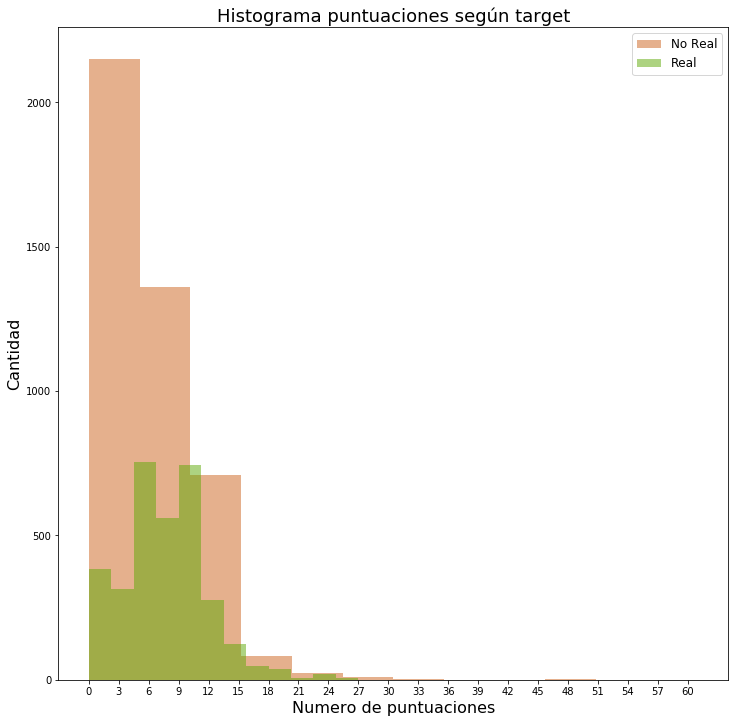

In [52]:
df_plot_1 = df_punctuations_red[df_punctuations_red.target == 'Real']
df_plot_0 =df_punctuations_red[df_punctuations_red.target == 'No Real']
plt.figure(figsize=(12,12))
sns.distplot(df_plot_0['num_punctuations'],  kde=False,label='No Real', bins=bin_quant,
            hist_kws={"alpha": 0.45, "color": "#c65102"})
sns.distplot(df_plot_1['num_punctuations'],  kde=False, label='Real',bins=bin_quant,
            hist_kws={"alpha": 0.5, "color": "#5ca904"})
plt.legend(prop={'size': 12})
plt.title('Histograma puntuaciones según target',size=18)
plt.xlabel('Numero de puntuaciones',size=16)
plt.xticks(np.arange(min(df_punctuations_red['num_punctuations']), max(df_punctuations_red['num_punctuations'])+1, 3))
plt.ylabel('Cantidad',size=16)
if savefigs:
    plt.savefig('figs/hist_puntuacion.png', bbox_inches='tight')
plt.show()

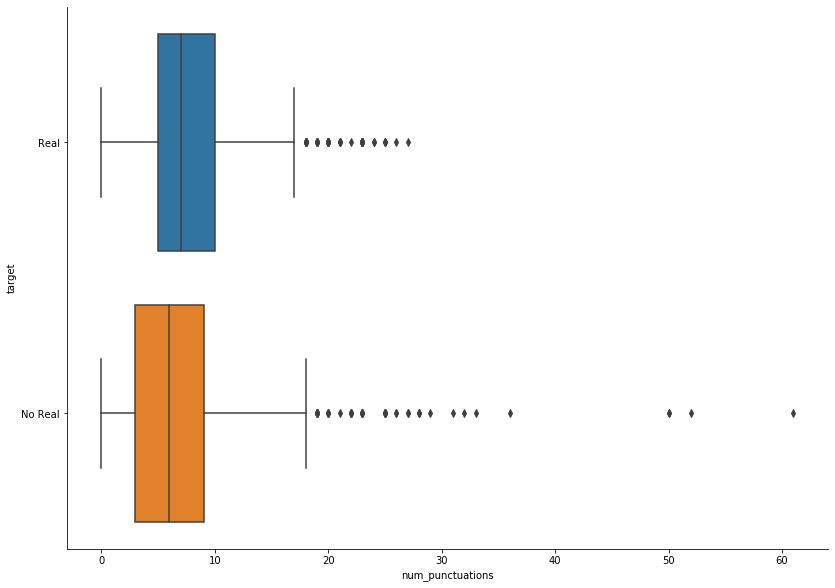

In [53]:
sns.catplot(x="num_punctuations", y="target", kind="box", data=df_punctuations_red,height=8.27, aspect=11.7/8.27);
if savefigs:
    plt.savefig('figs/boxplot_punt.png', bbox_inches='tight')

## Numero de palabras

In [39]:
dict_0 = defaultdict(int)
for word in words_0:
    if not (word.lower() in stopwords) and not (word.lower() in puntuacion):
        dict_0[word.lower()]+=1
        
top_0=sorted(dict_0.items(), key=lambda x:x[1],reverse=True)[:50] 

In [40]:
dict_1 = defaultdict(int)
for word in words_1:
    if not (word.lower() in stopwords) and not (word.lower() in puntuacion):
        dict_1[word.lower()]+=1
        
top_1=sorted(dict_1.items(), key=lambda x:x[1],reverse=True)[:50] 

In [41]:
top_0_df = pd.DataFrame(top_0,columns=['word_count','quantity'])
top_1_df = pd.DataFrame(top_1,columns=['word_count','quantity'])

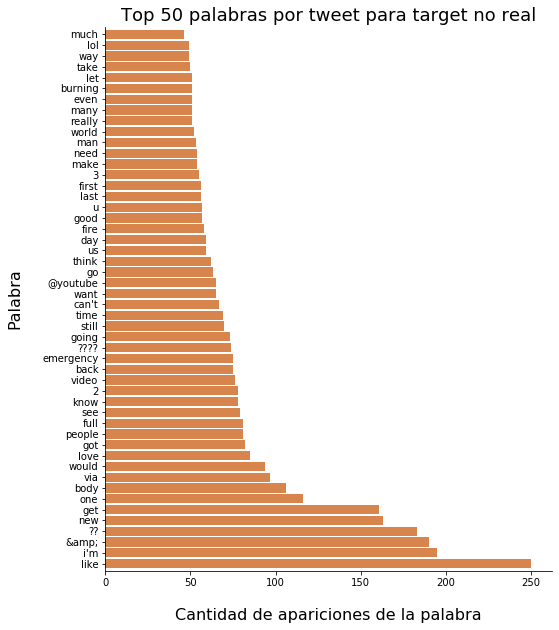

In [42]:
ax = top_0_df.plot(kind='barh', x=0,figsize=(8, 10), color='#c65102', zorder=2,
                   width=0.85,
                  legend=False, alpha=0.7)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Set x-axis label
ax.set_xlabel("Cantidad de apariciones de la palabra", labelpad=20, size=16)

# Set y-axis label
ax.set_ylabel("Palabra", labelpad=20, size=16)
plt.title('Top 50 palabras por tweet para target no real',size=18)
if savefigs:
    plt.savefig('figs/top50_palabras_no_real.png', bbox_inches='tight')
plt.show()

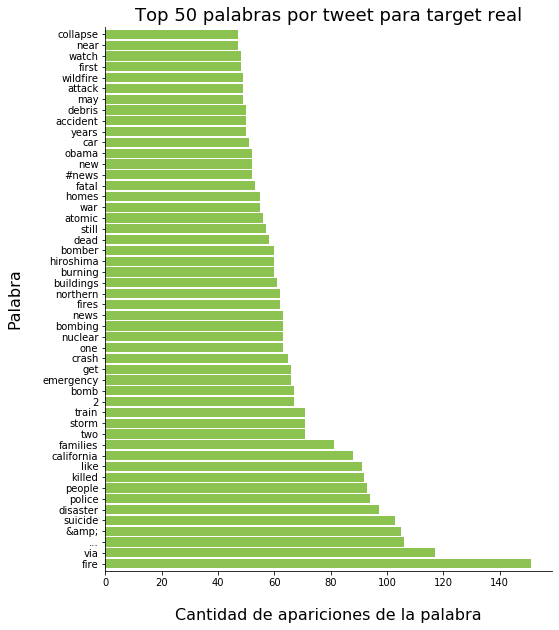

In [43]:
ax = top_1_df.plot(kind='barh', x=0,figsize=(8, 10), color='#5ca904', zorder=2,
                   width=0.85,
                  legend=False,alpha=0.7)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Set x-axis label
ax.set_xlabel("Cantidad de apariciones de la palabra", labelpad=20, size=16)

# Set y-axis label
ax.set_ylabel("Palabra", labelpad=20, size=16)
plt.title('Top 50 palabras por tweet para target real',size=18)
if savefigs:
    plt.savefig('figs/top50_palabras_real.png', bbox_inches='tight')
plt.show()

In [39]:
df["num_words"] = df["text"].apply(lambda x: len(str(x).split()))

In [45]:
df_word_count = df.copy()

In [46]:
#cambio los valores del target para mayor entendimiento en el grafico
mapping = {0: 'No Real', 1: "Real"}
df_word_count.replace({'target': mapping},inplace=True)

In [47]:
df_word_count_red = df_word_count.loc[:,['num_words','target']]

In [48]:
bin_quant = (max(df_word_count_red['num_words']) - min(df_word_count_red['num_words'])) / 1.1
bin_quant = round(bin_quant)

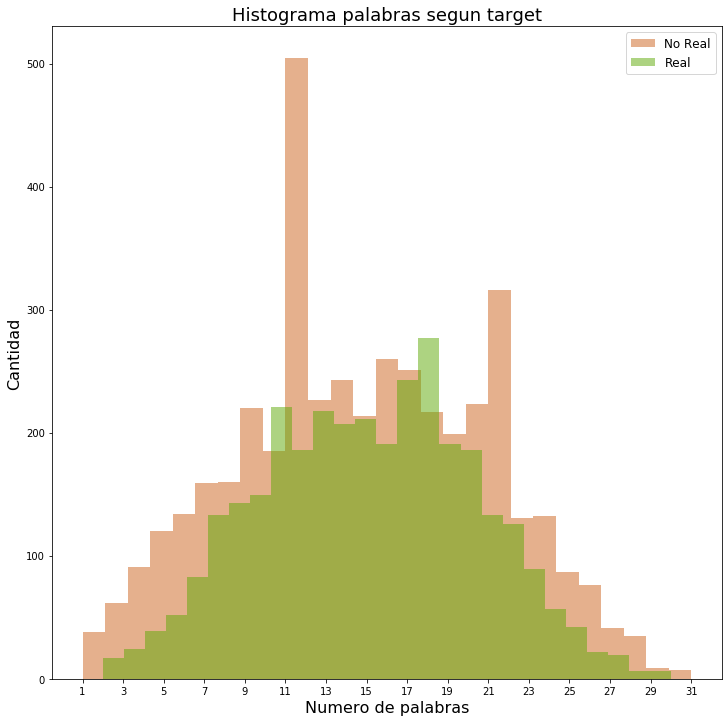

In [49]:
df_plot_1 = df_word_count_red[df_word_count_red.target == 'Real']
df_plot_0 =df_word_count_red[df_word_count_red.target == 'No Real']
plt.figure(figsize=(12,12))
sns.distplot(df_plot_0['num_words'],  kde=False,label='No Real', bins=bin_quant,
            hist_kws={"alpha": 0.45, "color": "#c65102"})
sns.distplot(df_plot_1['num_words'],  kde=False, label='Real',bins=bin_quant,
            hist_kws={"alpha": 0.5, "color": "#5ca904"})
plt.legend(prop={'size': 12})
plt.title('Histograma palabras segun target',size=18)
plt.xlabel('Numero de palabras',size=16)
plt.xticks(np.arange(min(df_word_count_red['num_words']), max(df_word_count_red['num_words'])+1, 2))
plt.ylabel('Cantidad',size=16)
if savefigs:
    plt.savefig('figs/hist_palabras.png', bbox_inches='tight')
plt.show()

## Palabras en mayuscula

In [61]:
dict_0 = defaultdict(int)
for word in words_0:
    if not (word in stopwords) and not (word in puntuacion):
        if(word.isupper()):
            dict_0[word]+=1
        
top_0=sorted(dict_0.items(), key=lambda x:x[1],reverse=True)[:50] 

In [62]:
dict_1 = defaultdict(int)
for word in words_1:
    if not (word in stopwords) and not (word in puntuacion):
        if(word.isupper()):
            dict_1[word]+=1
        
top_1=sorted(dict_1.items(), key=lambda x:x[1],reverse=True)[:50] 

In [63]:
top_0_df = pd.DataFrame(top_0,columns=['mayus_count','quantity'])
top_1_df = pd.DataFrame(top_1,columns=['mayus_count','quantity'])

top_0_df['quantity'] = np.log(top_0_df['quantity'])
top_1_df['quantity'] = np.log(top_1_df['quantity'])

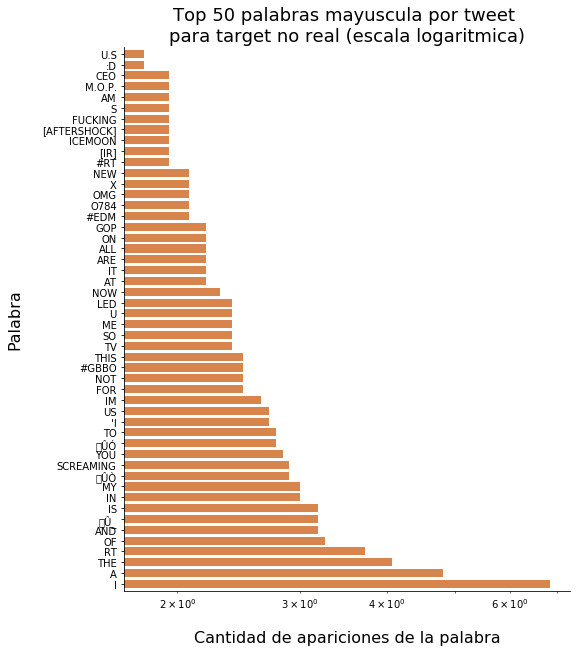

In [66]:
ax = top_0_df.plot(kind='barh', x=0,figsize=(8, 10), color='#c65102', zorder=2,
                   width=0.75,title ='',logx=True,
                  legend=False,alpha=0.7)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Set x-axis label
ax.set_xlabel("Cantidad de apariciones de la palabra", labelpad=20, size=16)

# Set y-axis label
ax.set_ylabel("Palabra", labelpad=20, size=16)
plt.title('Top 50 palabras mayuscula por tweet \npara target no real (escala logaritmica)',size=18)
if savefigs:
    plt.savefig('figs/top50_palabras_mayus_no_real.png', bbox_inches='tight')
plt.show()

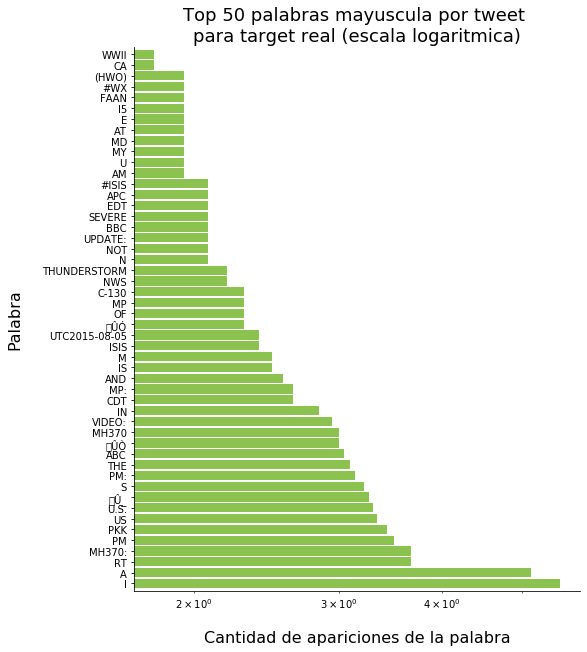

In [67]:
ax = top_1_df.plot(kind='barh', x=0,figsize=(8, 10), color='#5ca904', zorder=2,
                   width=0.85,logx=True,
                  legend=False,alpha=0.7)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Set x-axis label
ax.set_xlabel("Cantidad de apariciones de la palabra", labelpad=20, size=16)

# Set y-axis label
ax.set_ylabel("Palabra", labelpad=20, size=16)
plt.title('Top 50 palabras mayuscula por tweet \npara target real (escala logaritmica)',size=18)
if savefigs:
    plt.savefig('figs/top50_palabras_mayus_real.png', bbox_inches='tight')
plt.show()

In [40]:
df["num_words_upper"] = df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

In [58]:
df_num_words_upper = df.copy()

In [59]:
#cambio los valores del target para mayor entendimiento en el grafico
mapping = {0: 'No Real', 1: "Real"}
df_num_words_upper.replace({'target': mapping},inplace=True)

In [60]:
df_num_words_upper_red = df_num_words_upper.loc[:,['num_words_upper','target']]

In [61]:
bin_quant = (max(df_num_words_upper_red['num_words_upper']) - min(df_num_words_upper_red['num_words_upper'])) / 1
bin_quant = round(bin_quant)

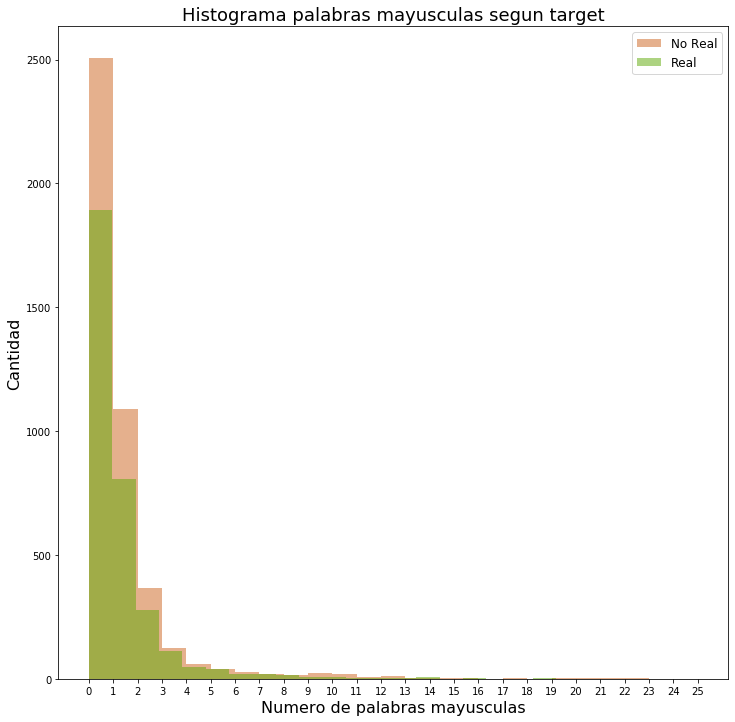

In [63]:
df_plot_1 = df_num_words_upper_red[df_num_words_upper_red.target == 'Real']
df_plot_0 =df_num_words_upper_red[df_num_words_upper_red.target == 'No Real']
plt.figure(figsize=(12,12))
sns.distplot(df_plot_0['num_words_upper'],  kde=False,label='No Real', bins=bin_quant,
            hist_kws={"alpha": 0.45, "color": "#c65102"})
sns.distplot(df_plot_1['num_words_upper'],  kde=False, label='Real',bins=bin_quant,
            hist_kws={"alpha": 0.5, "color": "#5ca904"})
plt.legend(prop={'size': 12})
plt.title('Histograma palabras mayusculas segun target',size=18)
plt.xlabel('Numero de palabras mayusculas',size=16)
plt.xticks(np.arange(min(df_num_words_upper_red['num_words_upper']), max(df_num_words_upper_red['num_words_upper'])+1, 1))
plt.ylabel('Cantidad',size=16)
if savefigs:
    plt.savefig('figs/hist_mayus.png', bbox_inches='tight')
plt.show()

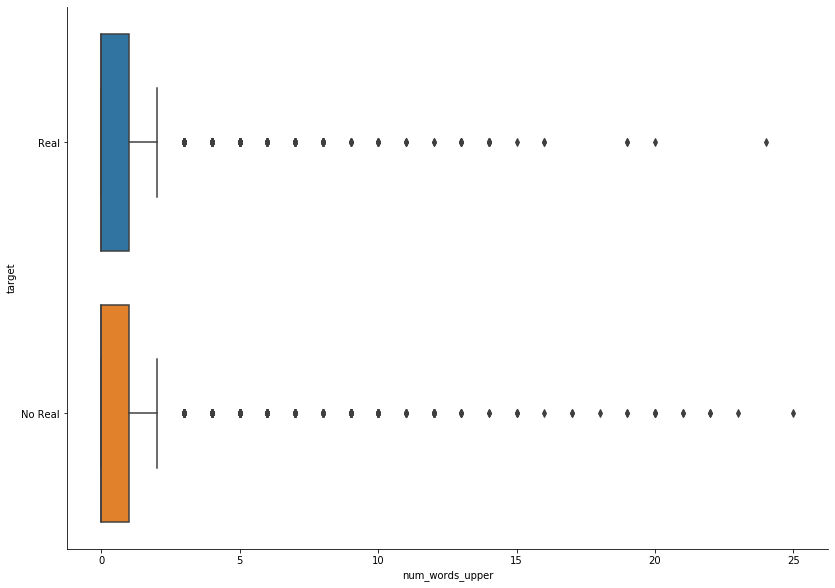

In [64]:
sns.catplot(x="num_words_upper", y="target", kind="box", data=df_num_words_upper_red,height=8.27, aspect=11.7/8.27);
if savefigs:
    plt.savefig('figs/boxplot_mayus.png', bbox_inches='tight')

## "Titulo" defecto de python (se fija las palabras con el primer caracter en mayuscula)

In [65]:
dict_0 = defaultdict(int)
for word in words_0:
    if not (word.lower() in stopwords) and not (word.lower() in puntuacion):
        if(word.istitle()):
            dict_0[word]+=1
        
top_0=sorted(dict_0.items(), key=lambda x:x[1],reverse=True)[:50] 

In [66]:
dict_1 = defaultdict(int)
for word in words_1:
    if not (word.lower() in stopwords) and not (word.lower() in puntuacion):
        if(word.istitle()):
            dict_1[word]+=1
        
top_1=sorted(dict_1.items(), key=lambda x:x[1],reverse=True)[:50] 

In [67]:
top_0_df = pd.DataFrame(top_0,columns=['title_count','quantity'])
top_1_df = pd.DataFrame(top_1,columns=['title_count','quantity'])

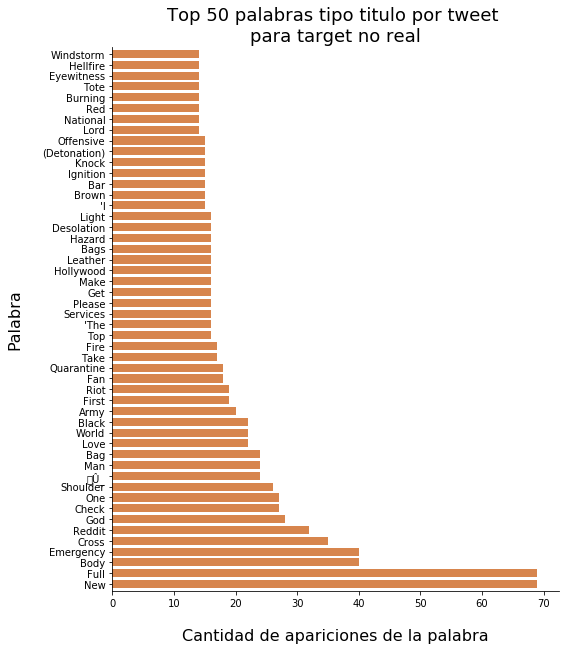

In [70]:
ax = top_0_df.plot(kind='barh', x=0,figsize=(8, 10), color='#c65102', zorder=2,
                   width=0.75,
                  legend=False,alpha=0.7)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Set x-axis label
ax.set_xlabel("Cantidad de apariciones de la palabra", labelpad=20, size=16)

# Set y-axis label
ax.set_ylabel("Palabra", labelpad=20, size=16)
plt.title('Top 50 palabras tipo titulo por tweet \npara target no real',size=18)
if savefigs:
    plt.savefig('figs/top50_titles_no_real.png', bbox_inches='tight')
plt.show()

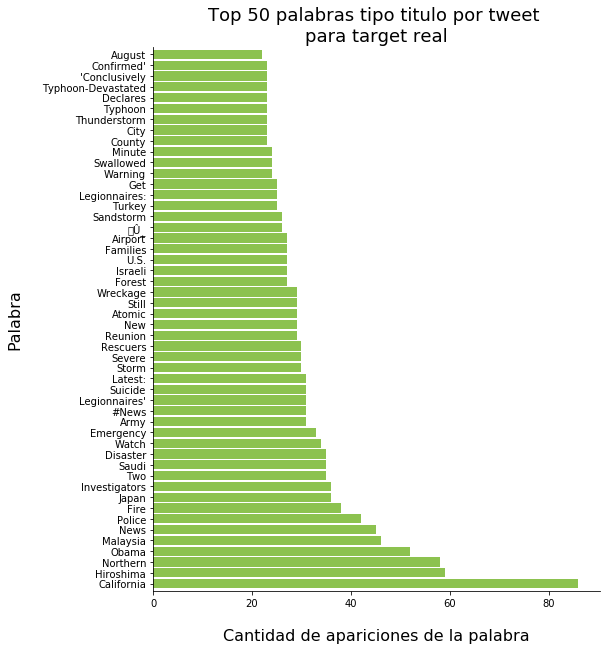

In [71]:
ax = top_1_df.plot(kind='barh', x=0,figsize=(8, 10), color='#5ca904', zorder=2,
                   width=0.85,
                  legend=False,alpha=0.7)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Set x-axis label
ax.set_xlabel("Cantidad de apariciones de la palabra", labelpad=20, size=16)

# Set y-axis label
ax.set_ylabel("Palabra", labelpad=20, size=16)
plt.title('Top 50 palabras tipo titulo por tweet \npara target real',size=18)
if savefigs:
    plt.savefig('figs/top50_titles_real.png', bbox_inches='tight')
plt.show()

In [41]:
df["num_words_title"] = df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

In [73]:
df_num_words_title = df.copy()

In [74]:
#cambio los valores del target para mayor entendimiento en el grafico
mapping = {0: 'No Real', 1: "Real"}
df_num_words_title.replace({'target': mapping},inplace=True)

In [75]:
df_num_words_title_red = df_num_words_title.loc[:,['num_words_title','target']]

In [76]:
bin_quant = (max(df_num_words_title_red['num_words_title']) - min(df_num_words_title_red['num_words_title'])) / 1
bin_quant = round(bin_quant)

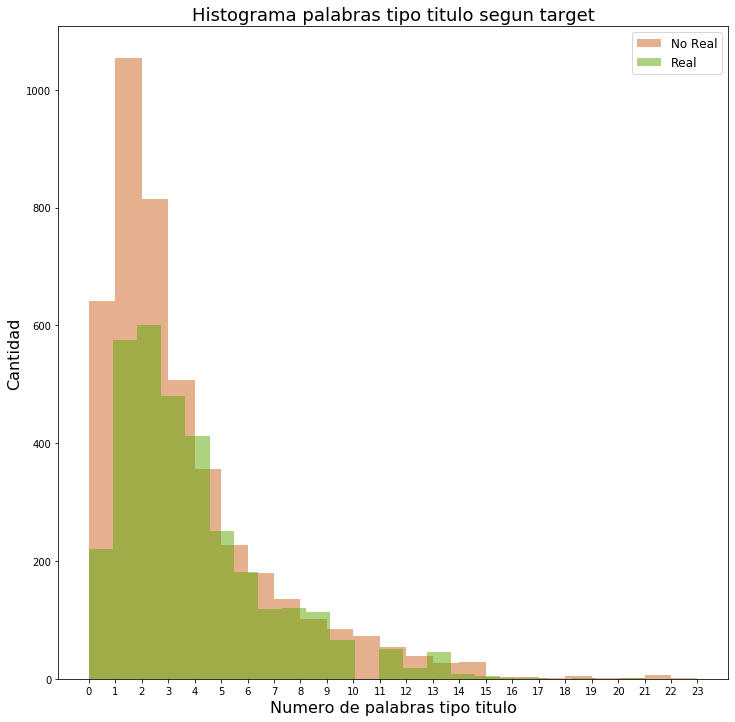

In [78]:
df_plot_1 = df_num_words_title_red[df_num_words_title_red.target == 'Real']
df_plot_0 =df_num_words_title_red[df_num_words_title_red.target == 'No Real']
plt.figure(figsize=(12,12))
sns.distplot(df_plot_0['num_words_title'],  kde=False,label='No Real', bins=bin_quant,
            hist_kws={"alpha": 0.45, "color": "#c65102"})
sns.distplot(df_plot_1['num_words_title'],  kde=False, label='Real',bins=bin_quant,
            hist_kws={"alpha": 0.5, "color": "#5ca904"})
plt.legend(prop={'size': 12})
plt.title('Histograma palabras tipo titulo segun target',size=18)
plt.xlabel('Numero de palabras tipo titulo',size=16)
plt.xticks(np.arange(min(df_num_words_title_red['num_words_title']), max(df_num_words_title_red['num_words_title'])+1, 1))
plt.ylabel('Cantidad',size=16)
if savefigs:
    plt.savefig('figs/hist_title.png', bbox_inches='tight')
plt.show()

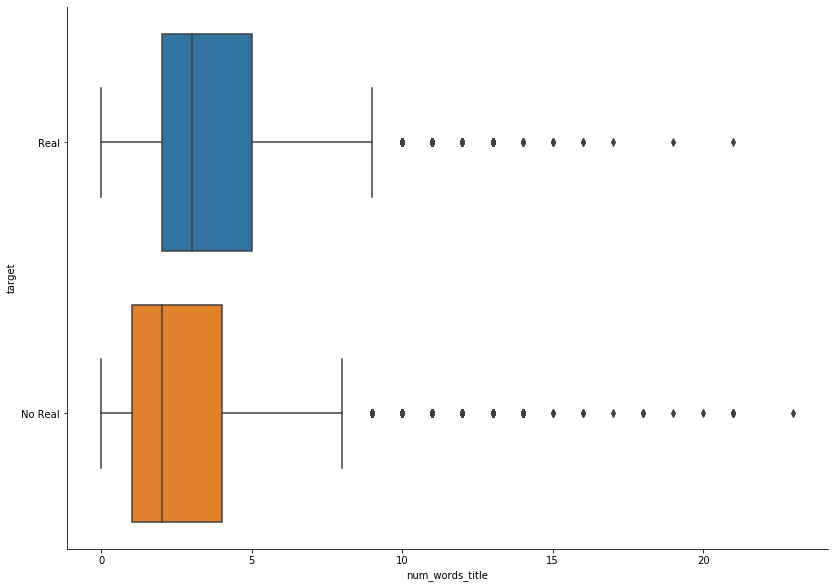

In [79]:
sns.catplot(x="num_words_title", y="target", kind="box", data=df_num_words_title_red,height=8.27, aspect=11.7/8.27);
if savefigs:
    plt.savefig('figs/boxplot_titles.png', bbox_inches='tight')

## Longitud promedio

In [42]:
df["mean_word_len"] = df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [43]:
df_mean_word_len = df.copy()

In [83]:
#cambio los valores del target para mayor entendimiento en el grafico
mapping = {0: 'No Real', 1: "Real"}
df_mean_word_len.replace({'target': mapping},inplace=True)

In [84]:
df_mean_word_len_red = df_mean_word_len.loc[:,['mean_word_len','target']]

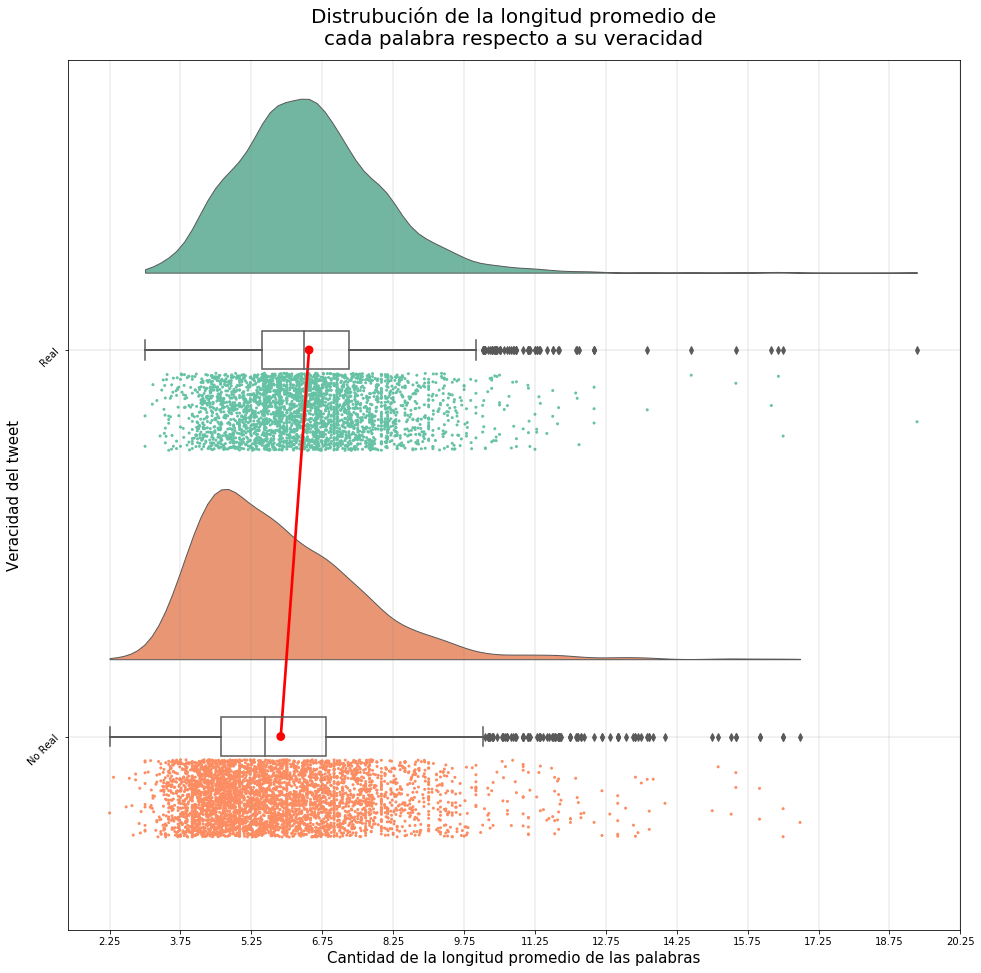

In [113]:
f, ax = plt.subplots(figsize =(16, 16)) 
ax = pt.RainCloud(x = "target", y = "mean_word_len", 
                  data = df_mean_word_len_red,
                  pointplot = True,
                  width_viol = .9,
                  width_box = .1,
                  orient = "h",
                  move = .16)

ax.set_title('Distrubución de la longitud promedio de\ncada palabra respecto a su veracidad',fontsize=20,pad=15)
ax.set_xlabel('Cantidad de la longitud promedio de las palabras',fontsize=15)
ax.set_ylabel('Veracidad del tweet',fontsize=15)
ax.grid(color='grey', linestyle='-', linewidth=0.3,alpha=0.75)
ax.set_xticks(np.arange(min(df_mean_word_len_red['mean_word_len']), max(df_mean_word_len_red['mean_word_len'])+1, 1.5))
plt.yticks(rotation=45)
if savefigs:
    plt.savefig('figs/promedio_raincloud.png', bbox_inches='tight')
plt.show()

## Caracteres

In [44]:
#hago una columna nueva con la longitud de tweets
df['text_length'] = df['text'].apply(len)

In [18]:
#cambio los valores del target para mayor entendimiento en el grafico
mapping = {0: 'No Real', 1: "Real"}
df.replace({'target': mapping},inplace=True)

In [19]:
df_red = df.loc[:,['text_length','target']]

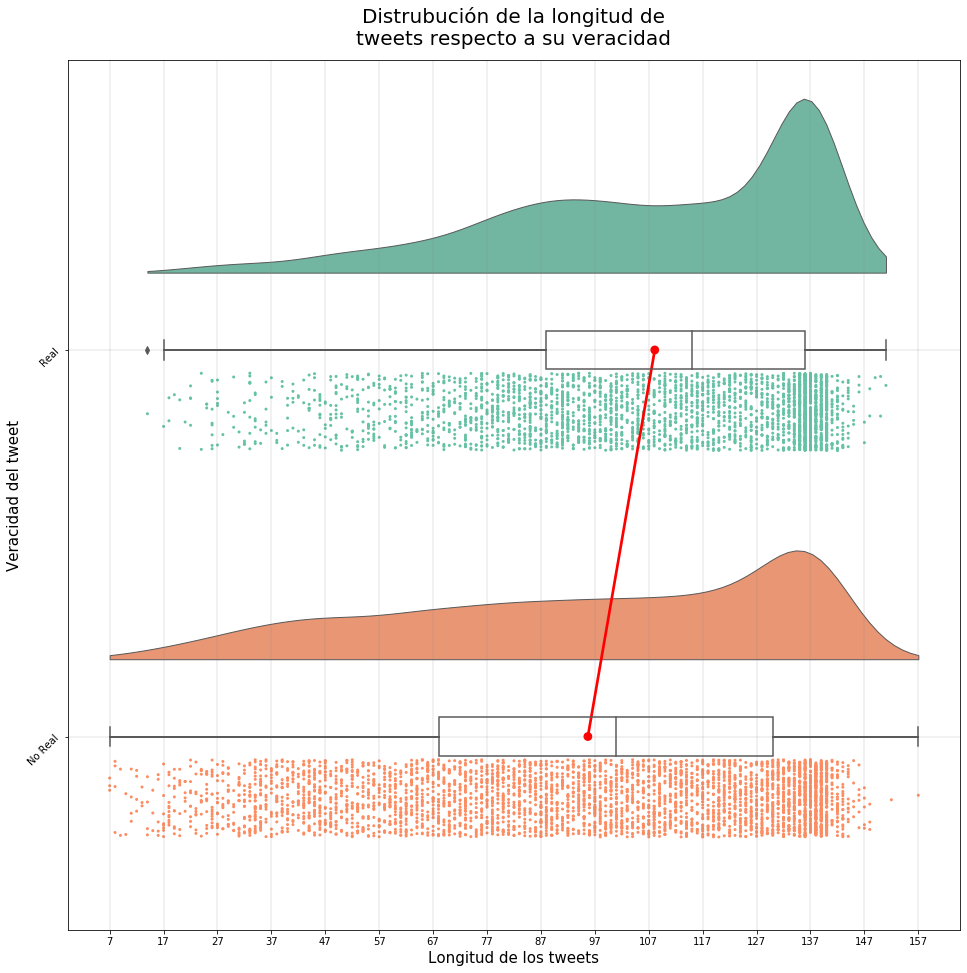

In [22]:
f, ax = plt.subplots(figsize =(16, 16)) 
ax = pt.RainCloud(x = "target", y = "text_length", 
                  data = df_red,
                  pointplot = True,
                  width_viol = .9,
                  width_box = .1,
                  orient = "h",
                  move = .16)

ax.set_title('Distrubución de la longitud de\ntweets respecto a su veracidad',fontsize=20,pad=15)
ax.set_xlabel('Longitud de los tweets',fontsize=15)
ax.set_ylabel('Veracidad del tweet',fontsize=15)
ax.grid(color='grey', linestyle='-', linewidth=0.3,alpha=0.75)
ax.set_xticks(np.arange(min(df_red['text_length']), max(df_red['text_length'])+1, 10))
plt.yticks(rotation=45)
if savefigs:
    plt.savefig('figs/char_raincloud.png', bbox_inches='tight')
plt.show()

# Relacion entre los features

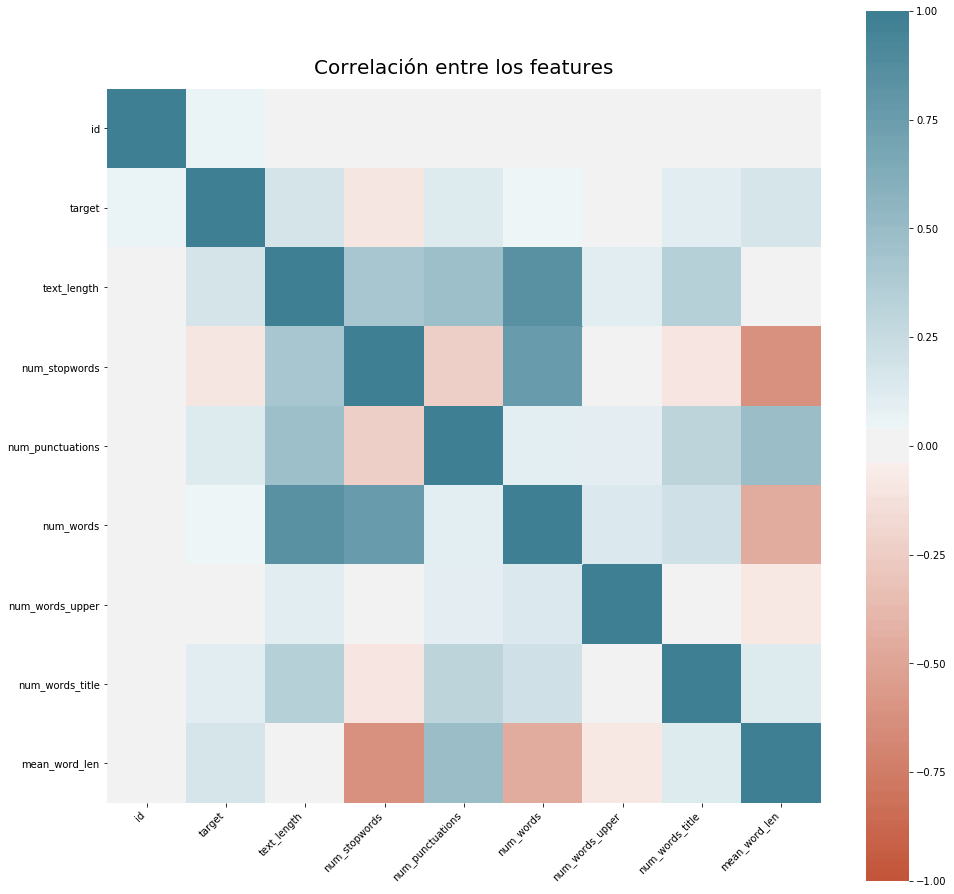

In [46]:
f, ax = plt.subplots(figsize =(16, 16)) 
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
ax.set_title('Correlación entre los features',fontsize=20,pad=15)
if savefigs:
    plt.savefig('figs/corr.png', bbox_inches='tight')
plt.show()